In [1]:
import signac
import matplotlib.pyplot as plt
import numpy as np
from cmeutils.structure import gsd_rdf, diffraction_pattern, get_quaternions, structure_factor
import gsd.hoomd

# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 2
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200

In [15]:
project = signac.get_project("../coarse-grain-sims/ti-ratio-melt-relaxation/polybinder-flow/")
lattice_project = signac.get_project("../coarse-grain-sims/crystals/polybinder-flow/")

(-42.0, -10.0)

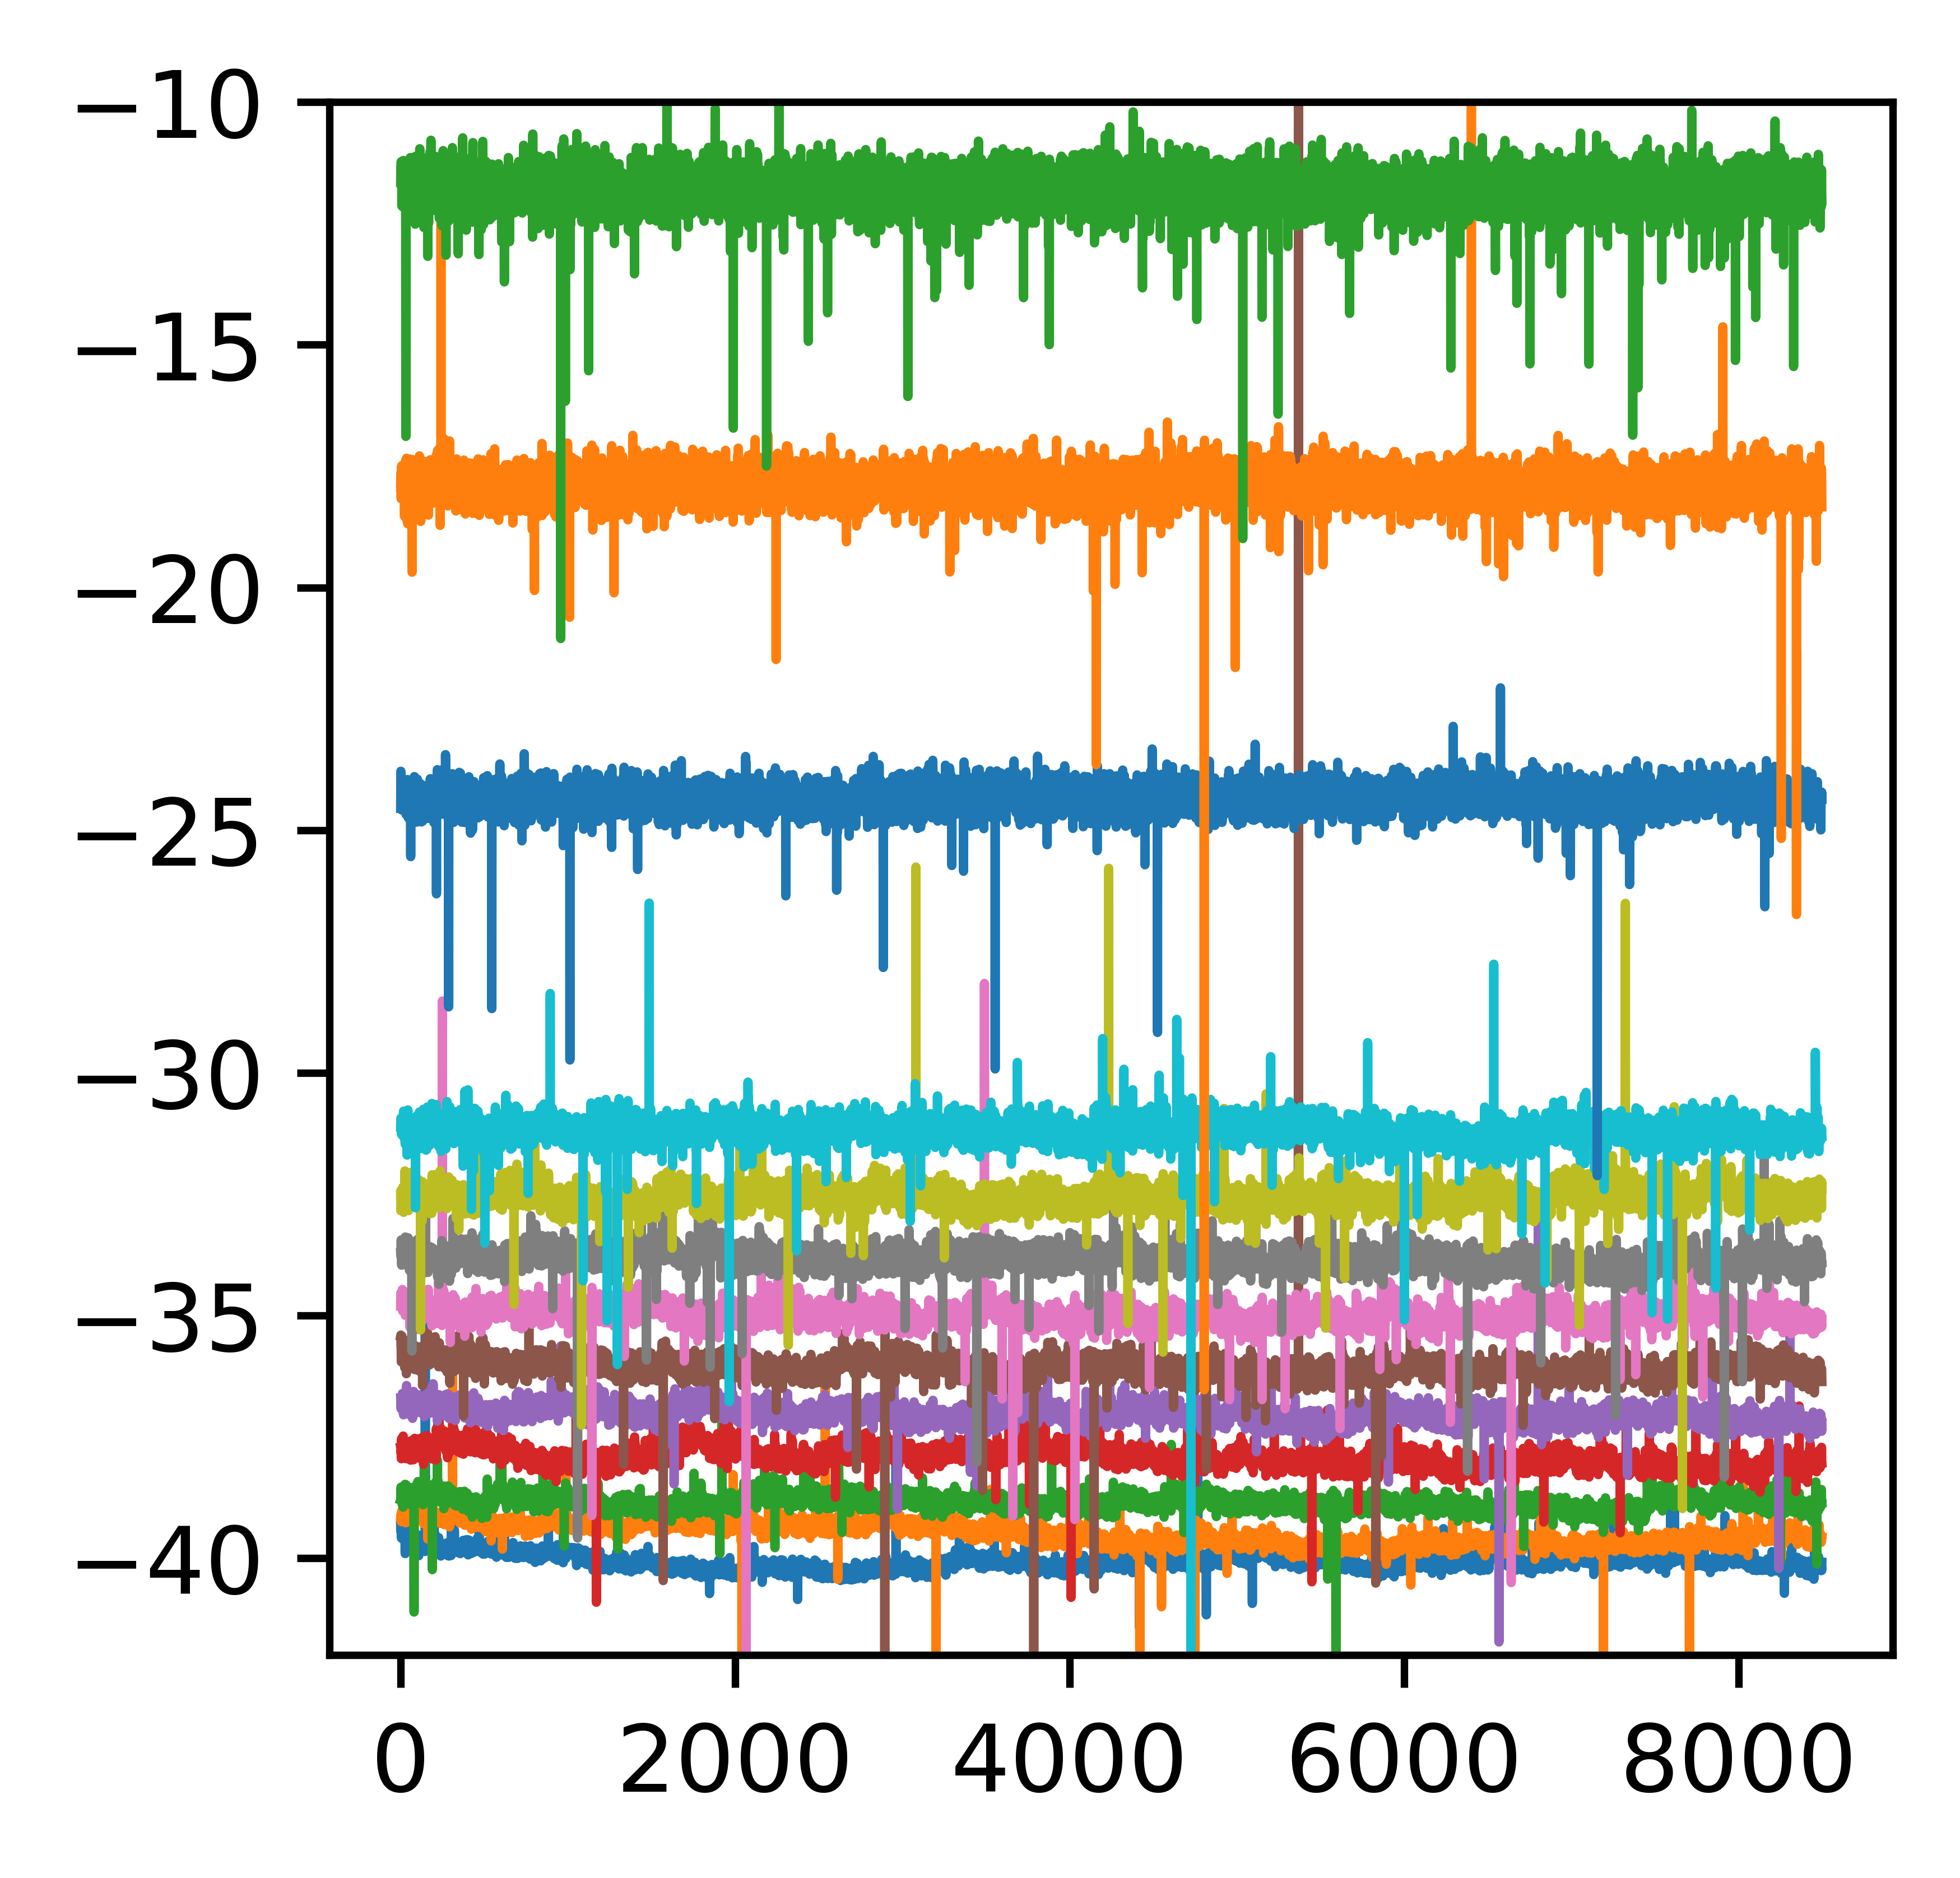

In [3]:
cut = 2000

for kT, jobs in project.find_jobs({"ekk_weight": 0.8}).groupby("kT_quench"):
    for job in jobs:
        data = np.genfromtxt(job.fn("sim_traj.txt"), names=True)
        N = job.sp.polymer_lengths[0] * job.sp.n_compounds[0]
        pe = data["mdcomputeThermodynamicQuantitiespotential_energy"] / N
        plt.plot(pe[cut:], label=kT, markersize=0)

plt.ylim(-42, -10)

6b99ae39136bb1a8dd218c7359e99b80
6cdfaa4277c79339884418070d88bd16
db0cb335666bad03e86fb012bc5e8789
b5e7a75b47fc026b72421e78e4c68dbc
a856e870219e03ee14e34d03ba3ac9db
dfeb315c856bf0717a1f36bba71746b8
a71ee9685f343fe89835c88ce5d1e3d2


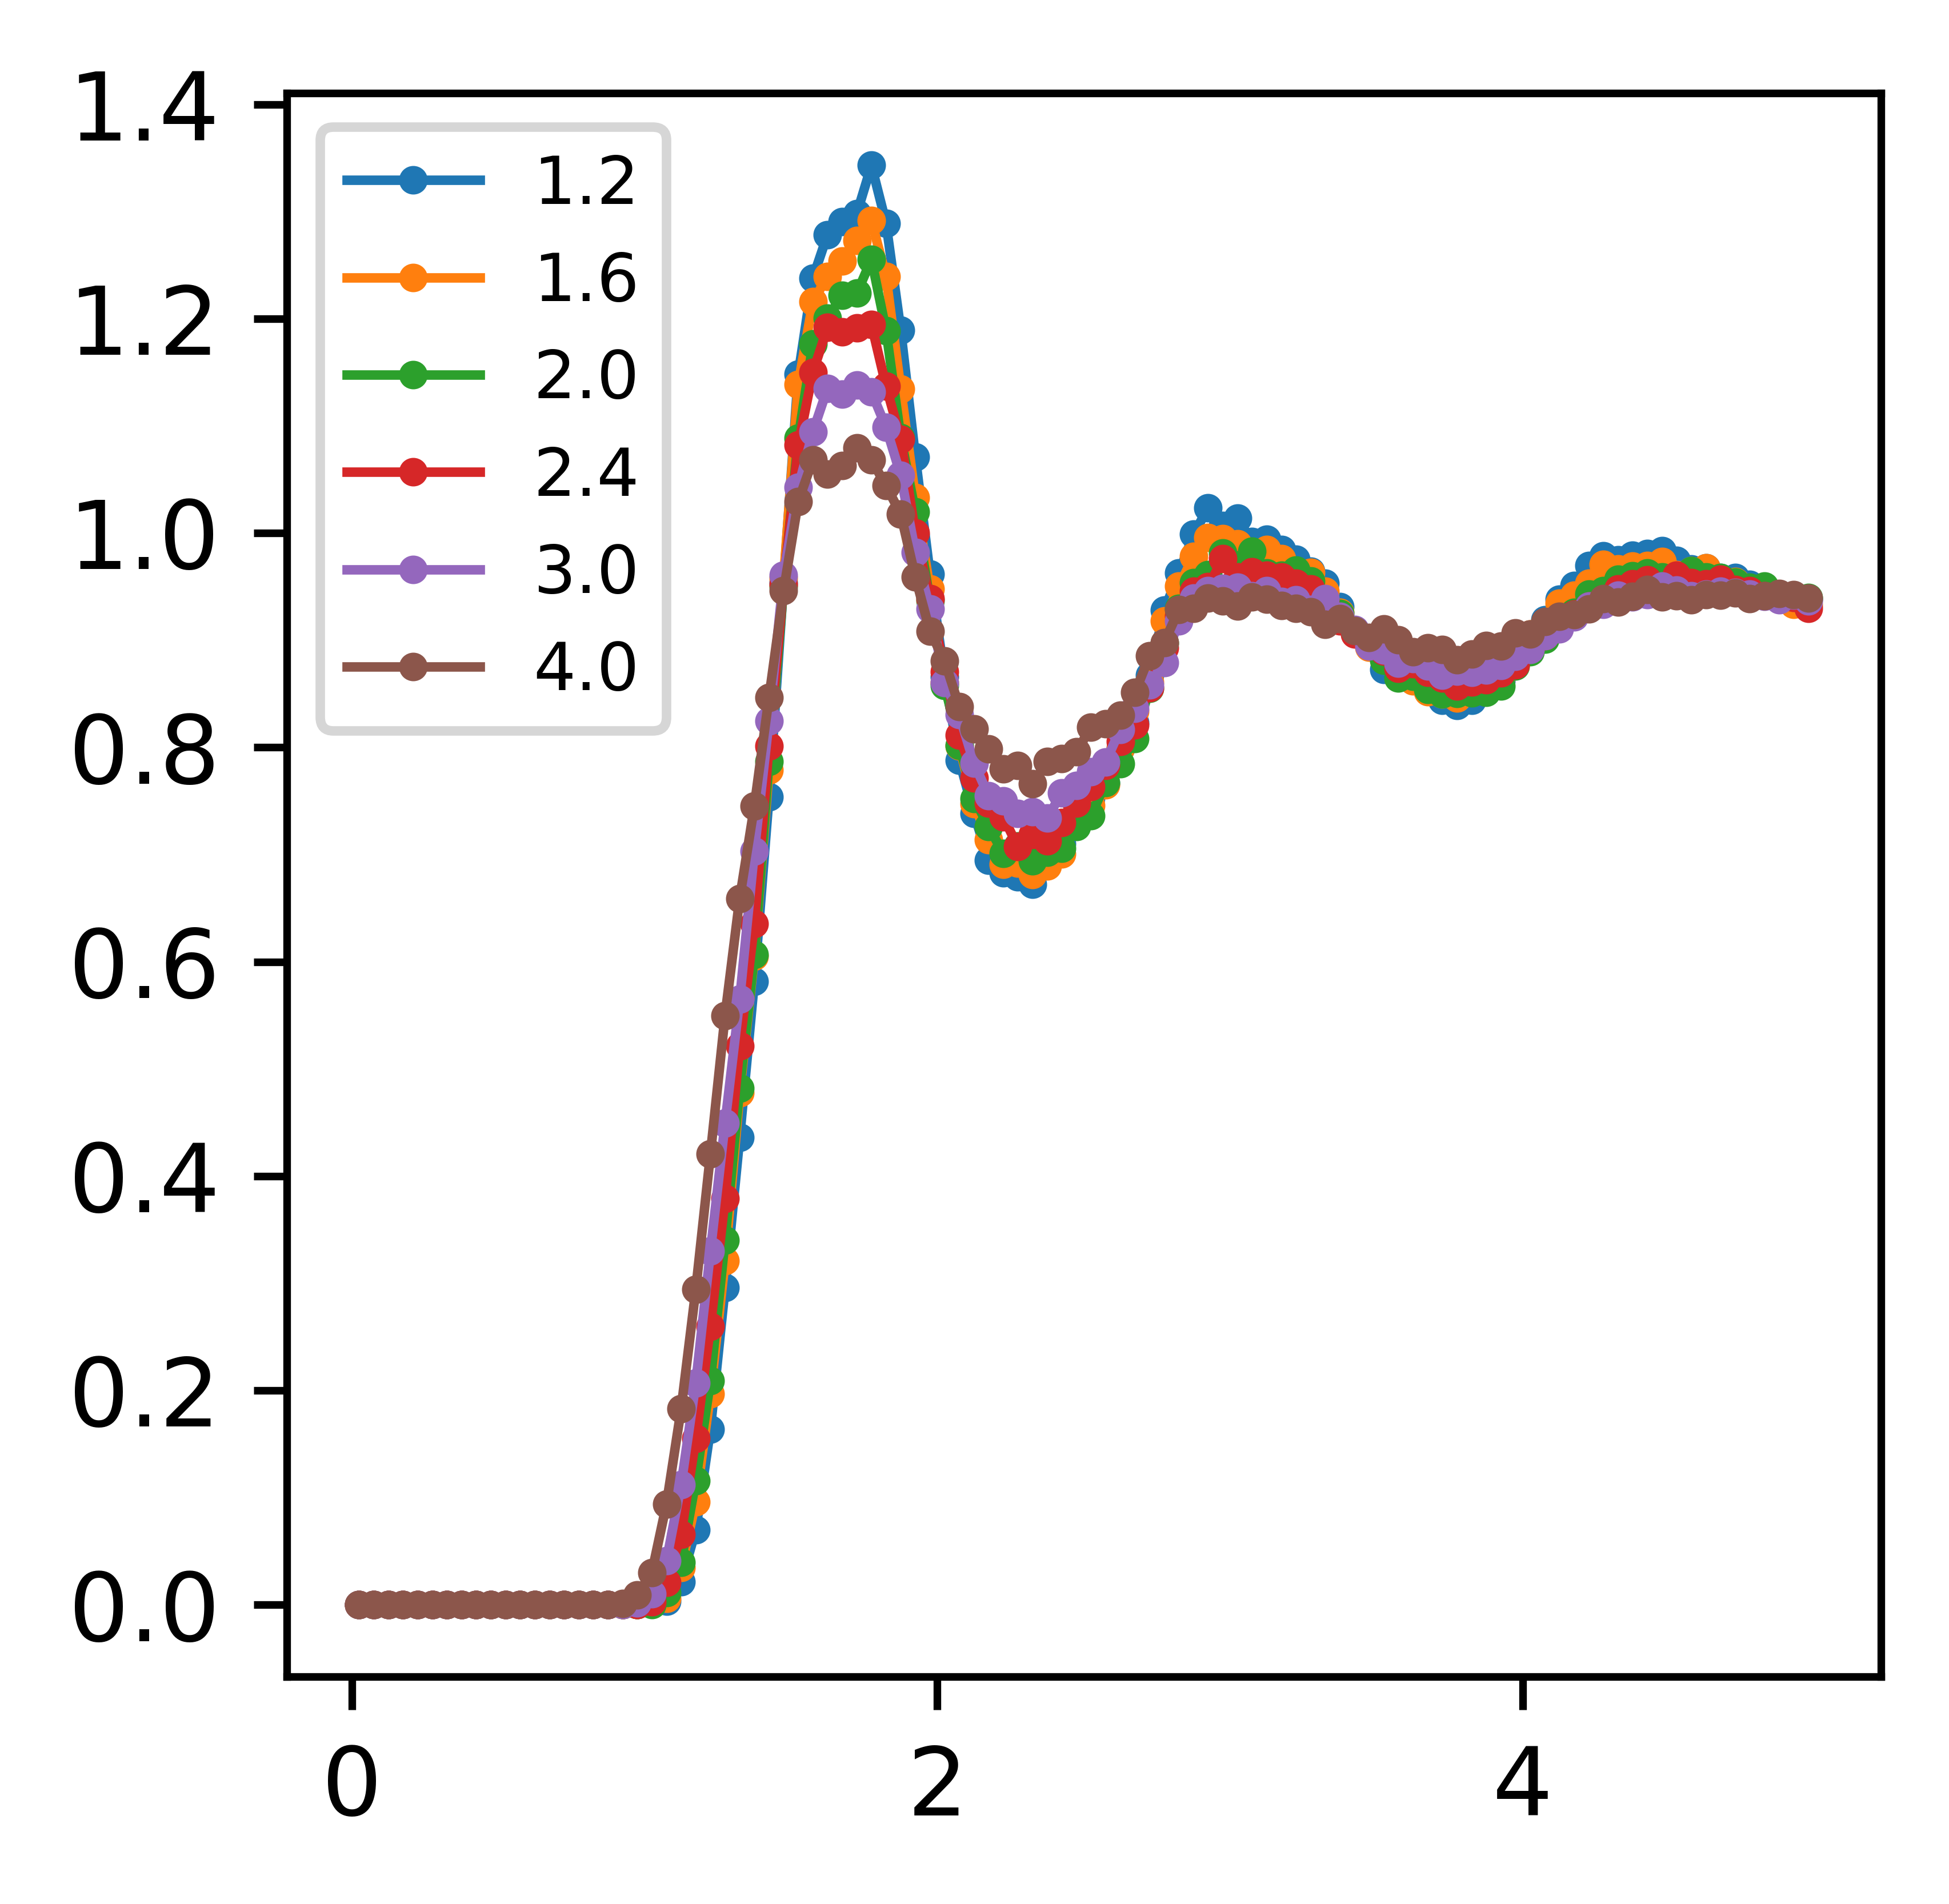

In [26]:
for kT, jobs in project.find_jobs({"ekk_weight": 1.0}).groupby("kT_quench"):
    for job in jobs:
        try:
            rdf, N = gsd_rdf(
                job.fn("sim_traj.gsd"),
                A_name="K",
                B_name="K",
                r_max=5.0,
                exclude_bonded=True,
                start=-20,
                stop=-1
            )

            plt.plot(rdf.bin_centers, rdf.rdf, label=kT)
        except:
            print(job.id)
        
plt.legend()

In [28]:
job.sp

{'system_type': 'pack', 'molecule': 'PEKK', 'para_weight': 1.0, 'ekk_weight': 0.8, 'kek_weight': 1.0, 'bonds': {'E-K': {'k': 850, 'r0': 1.47}, 'K-K': {'k': 1450, 'r0': 1.53}}, 'dihedrals': {'E-K-K-E': {'k': 16, 'phi0': 0, 'd': -1, 'n': 1}, 'K-E-K-K': {'k': 12, 'phi0': 0, 'd': -1, 'n': 1}}, 'monomer_sequence': None, 'density': 1.27, 'n_compounds': [100], 'polymer_lengths': [20], 'pdi': None, 'Mn': None, 'Mw': None, 'mass_dist': 'weibull', 'charges': None, 'forcefield': None, 'remove_hydrogens': True, 'system_seed': 42, 'box_constraints': None, 'kwargs': {}, 'signac_project': None, 'signac_args': None, 'restart_file': None, 'coarse_grain': True, 'ref_distance': 3.3997, 'ref_mass': 15.99, 'ref_energy': 0.21, 'cg_potentials_dir': 'msibi-deep', 'bead_mapping': 'ring_plus_linkage_AA', 'tau_kt': 0.3, 'tau_p': None, 'pressure': None, 'dt': 0.0003, 'r_cut': 4.0, 'e_factor': 1.0, 'sim_seed': 42, 'neighbor_list': 'Cell', 'walls': None, 'init_shrink_kT': 16.0, 'final_shrink_kT': 16.0, 'shrink_step

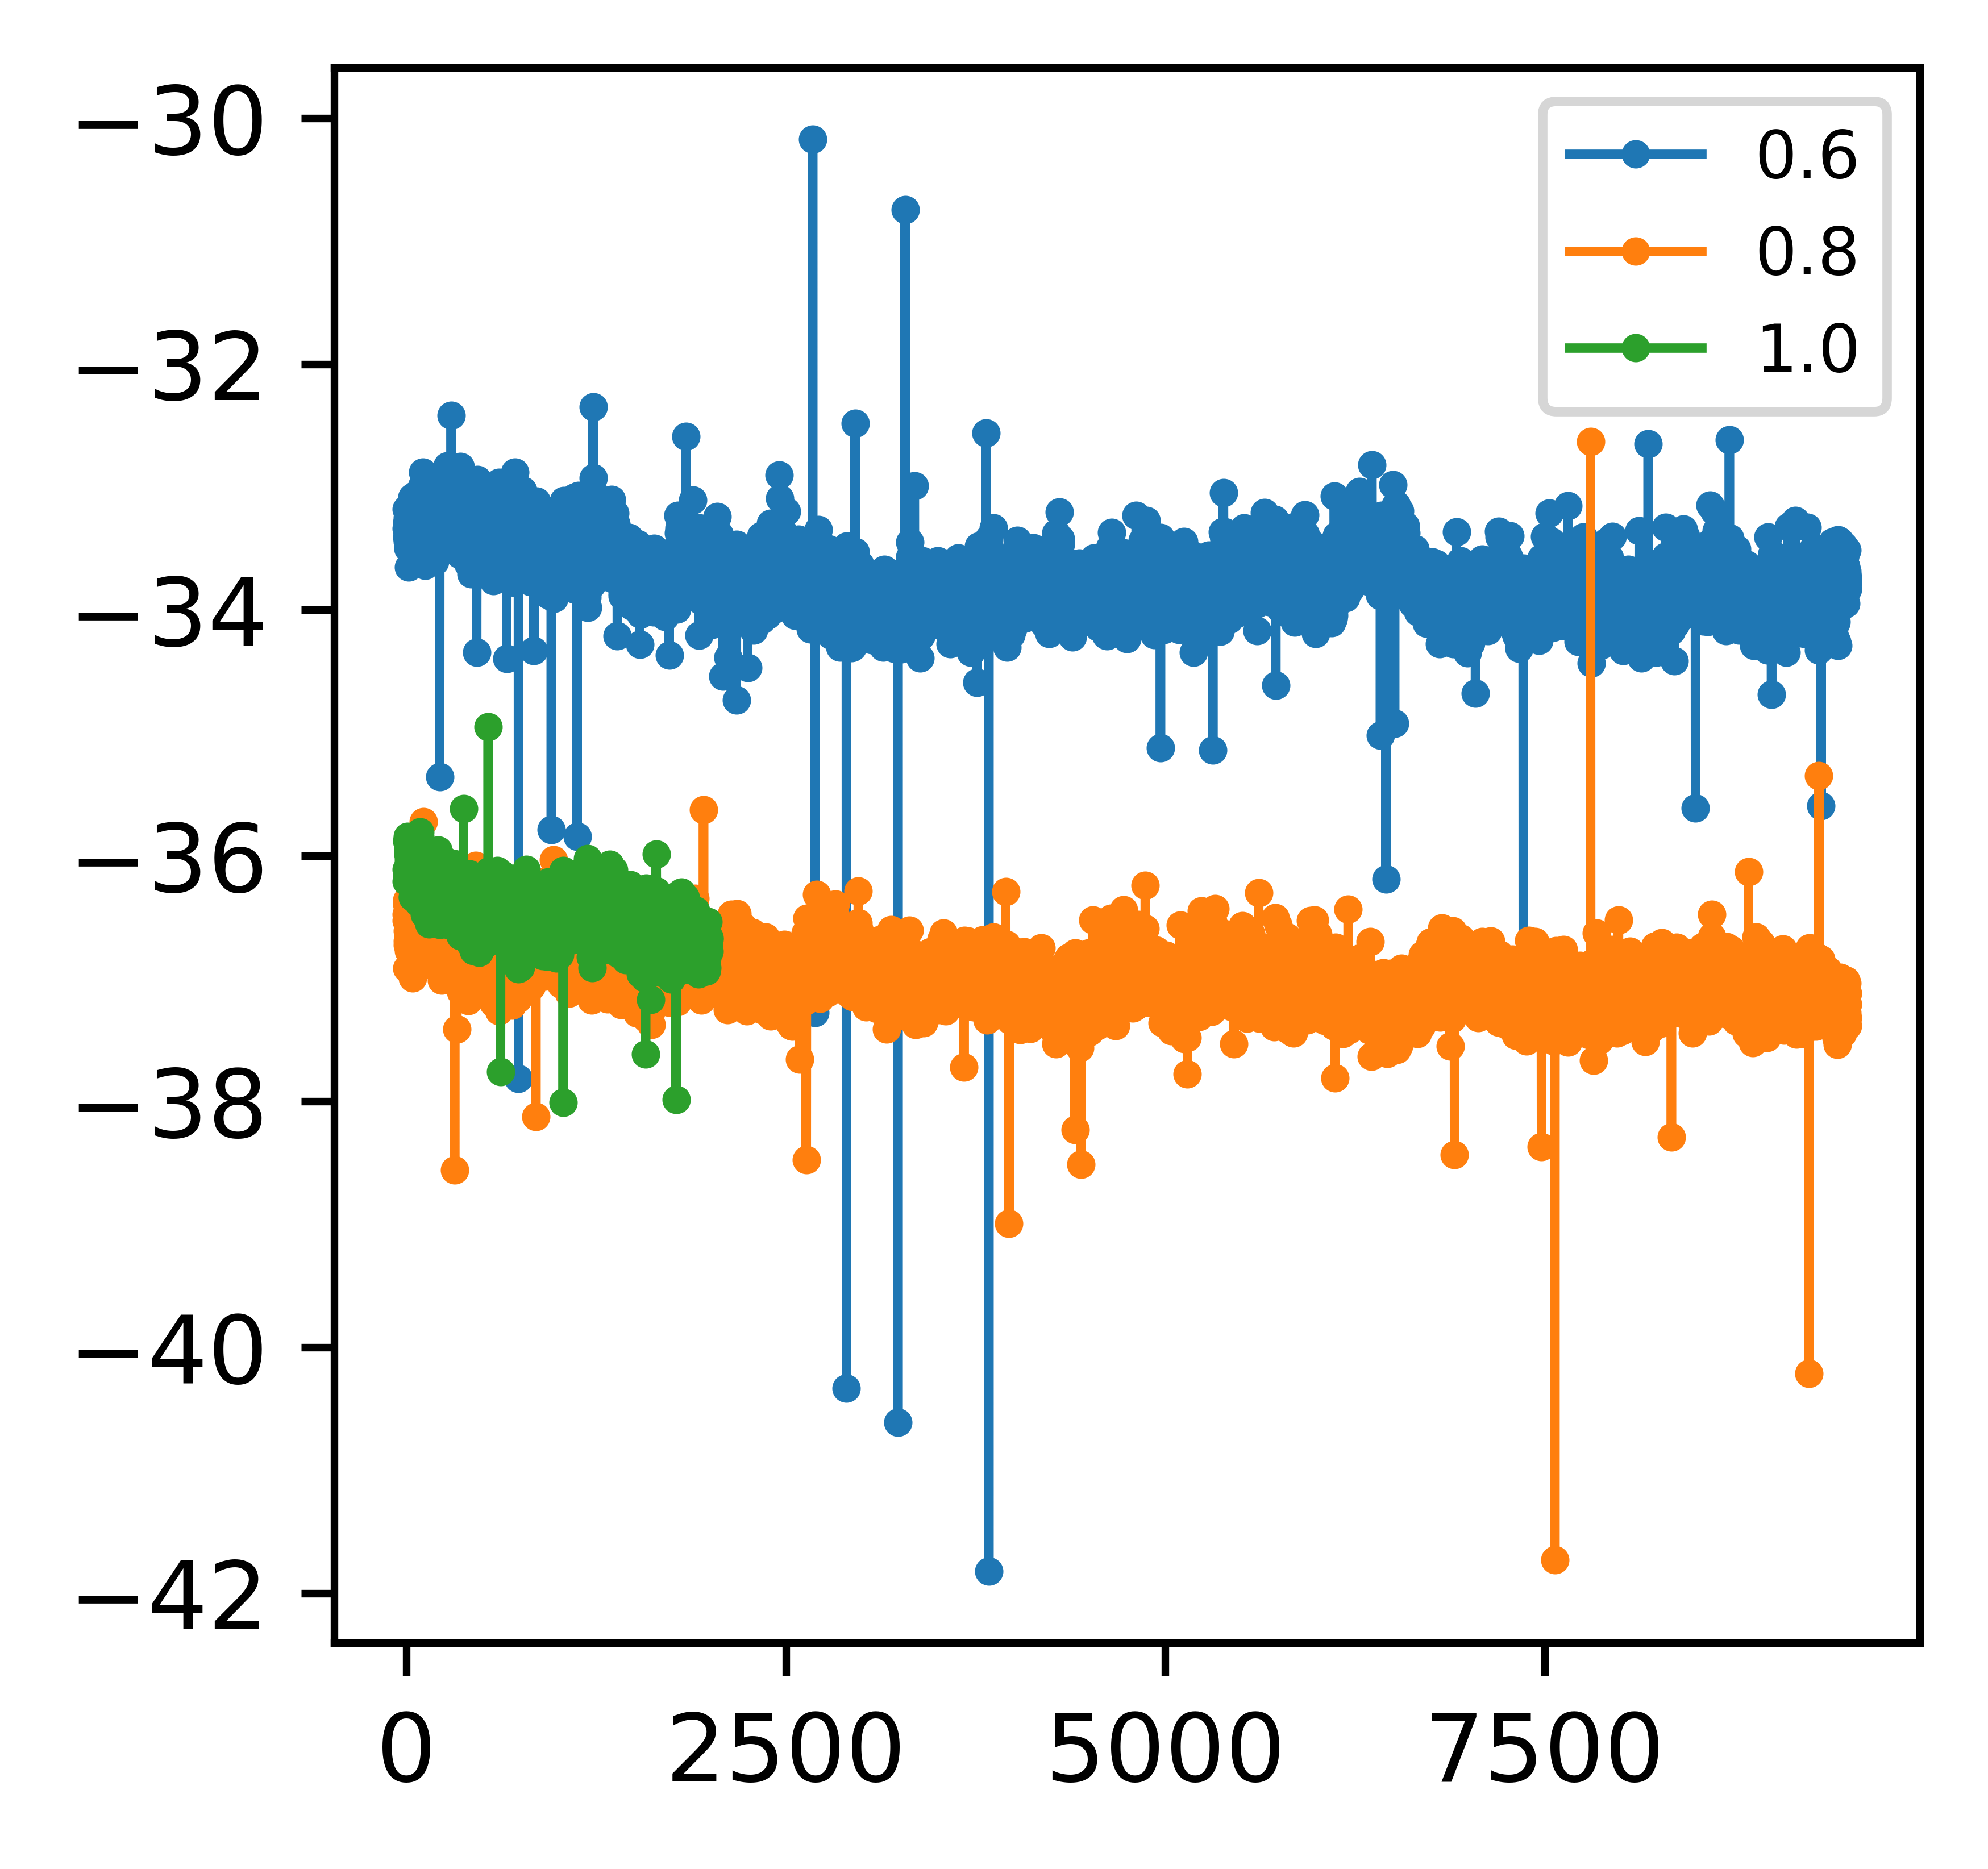

In [4]:
cut = 1000

for weight, jobs in project.find_jobs({"kT_quench": 2.0}).groupby("ekk_weight"):
    for job in jobs:
        N = job.sp.polymer_lengths[0] * job.sp.n_compounds[0]
        data = np.genfromtxt(job.fn("sim_traj.txt"), names=True)
        pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
        plt.plot(pe[cut:] / N, label=weight)
        
plt.legend()

0.6 955755c7d9080e45fbf872cea9700765
0.8 d4699b09185ecfc512c633273bd878bf
1.0 335d57e3a290f3e5397dec2ae26e21f0


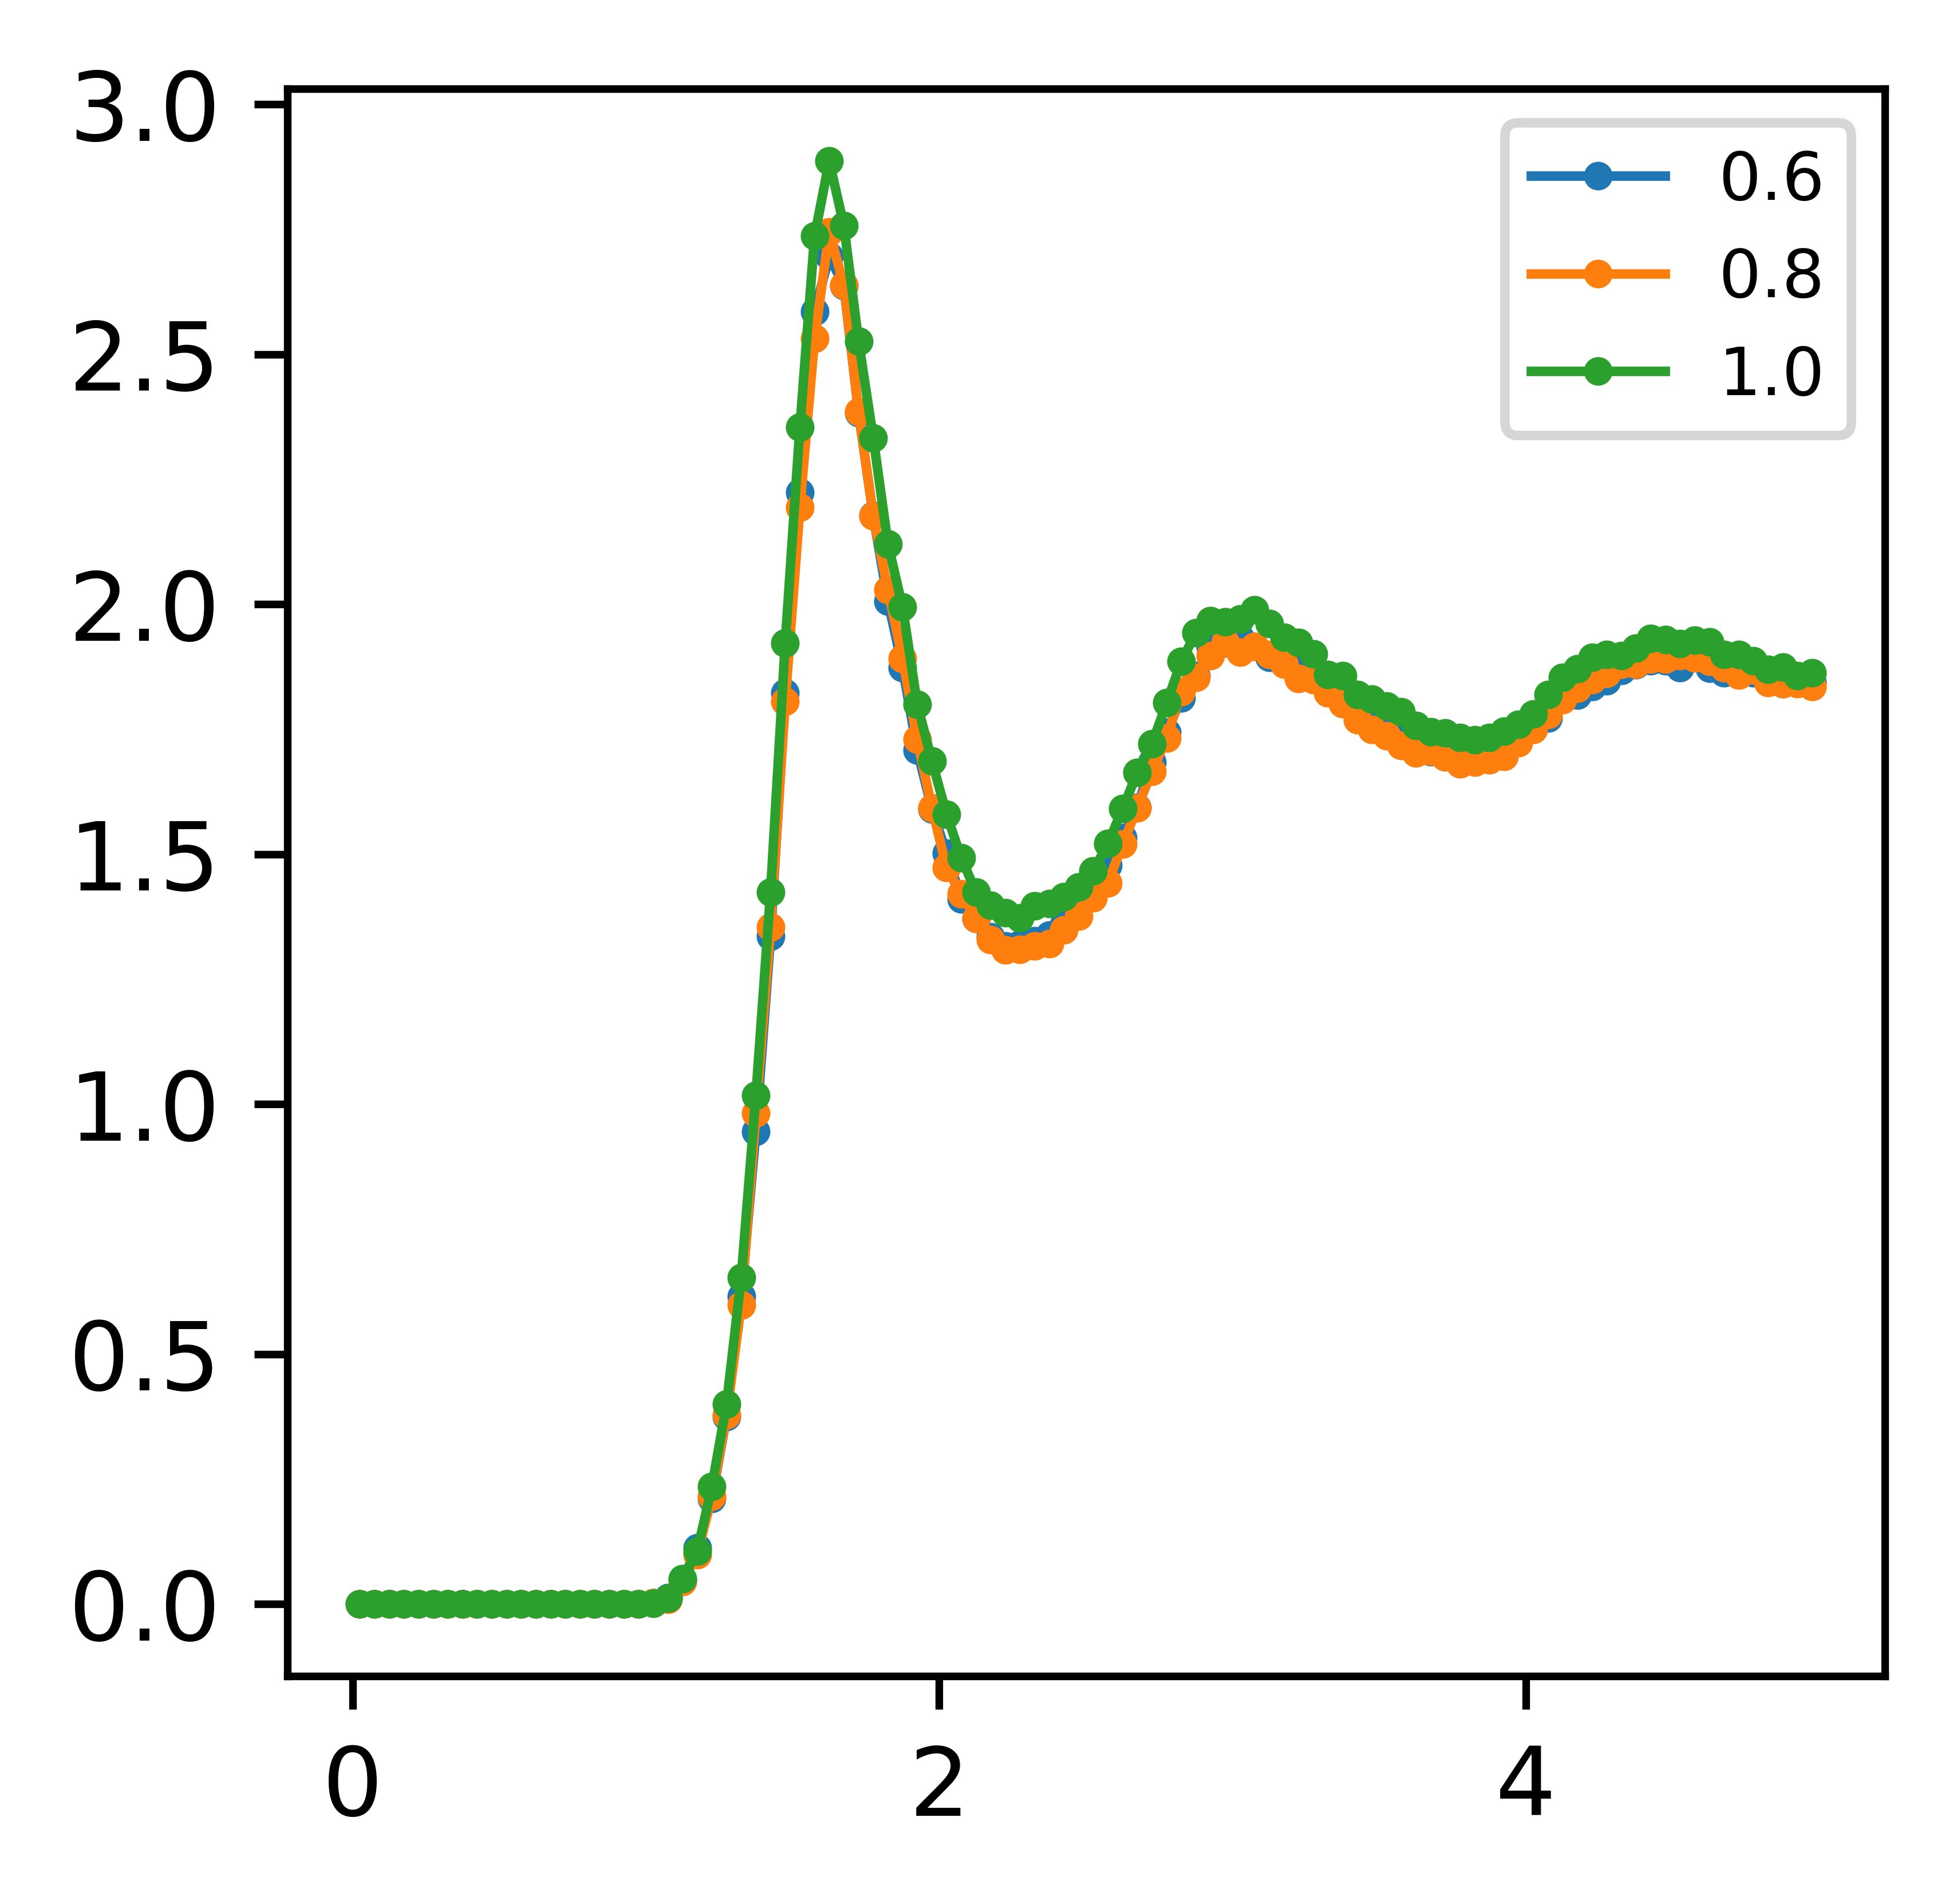

In [8]:
for weight, jobs in project.find_jobs({"kT_quench": 2.0}).groupby("ekk_weight"):
    for job in jobs:
        #if weight == 1.0: continue
        print(weight, job.id)
        rdf, N = gsd_rdf(
            job.fn("sim_traj.gsd"),
            A_name="E",
            B_name="K",
            r_max=5.0,
            exclude_bonded=True,
            start=-20,
            stop=-1
        )

        plt.plot(rdf.bin_centers, rdf.rdf, label=weight)
        
plt.legend()

In [12]:
job.doc

{'done': False, 'steps': 1000000000, 'sample_pdi': False, 'target_box': [9.227024586044815, 9.227024586044815, 9.227024586044815], 'ref_energy': 0.21, 'ref_distance': 3.3997, 'ref_mass': 15.99, 'real_timestep': 0.435, 'time_unit': 'fs', 'steps_per_frame': 500000, 'steps_per_log': 100000}

0.6
0.8
1.0


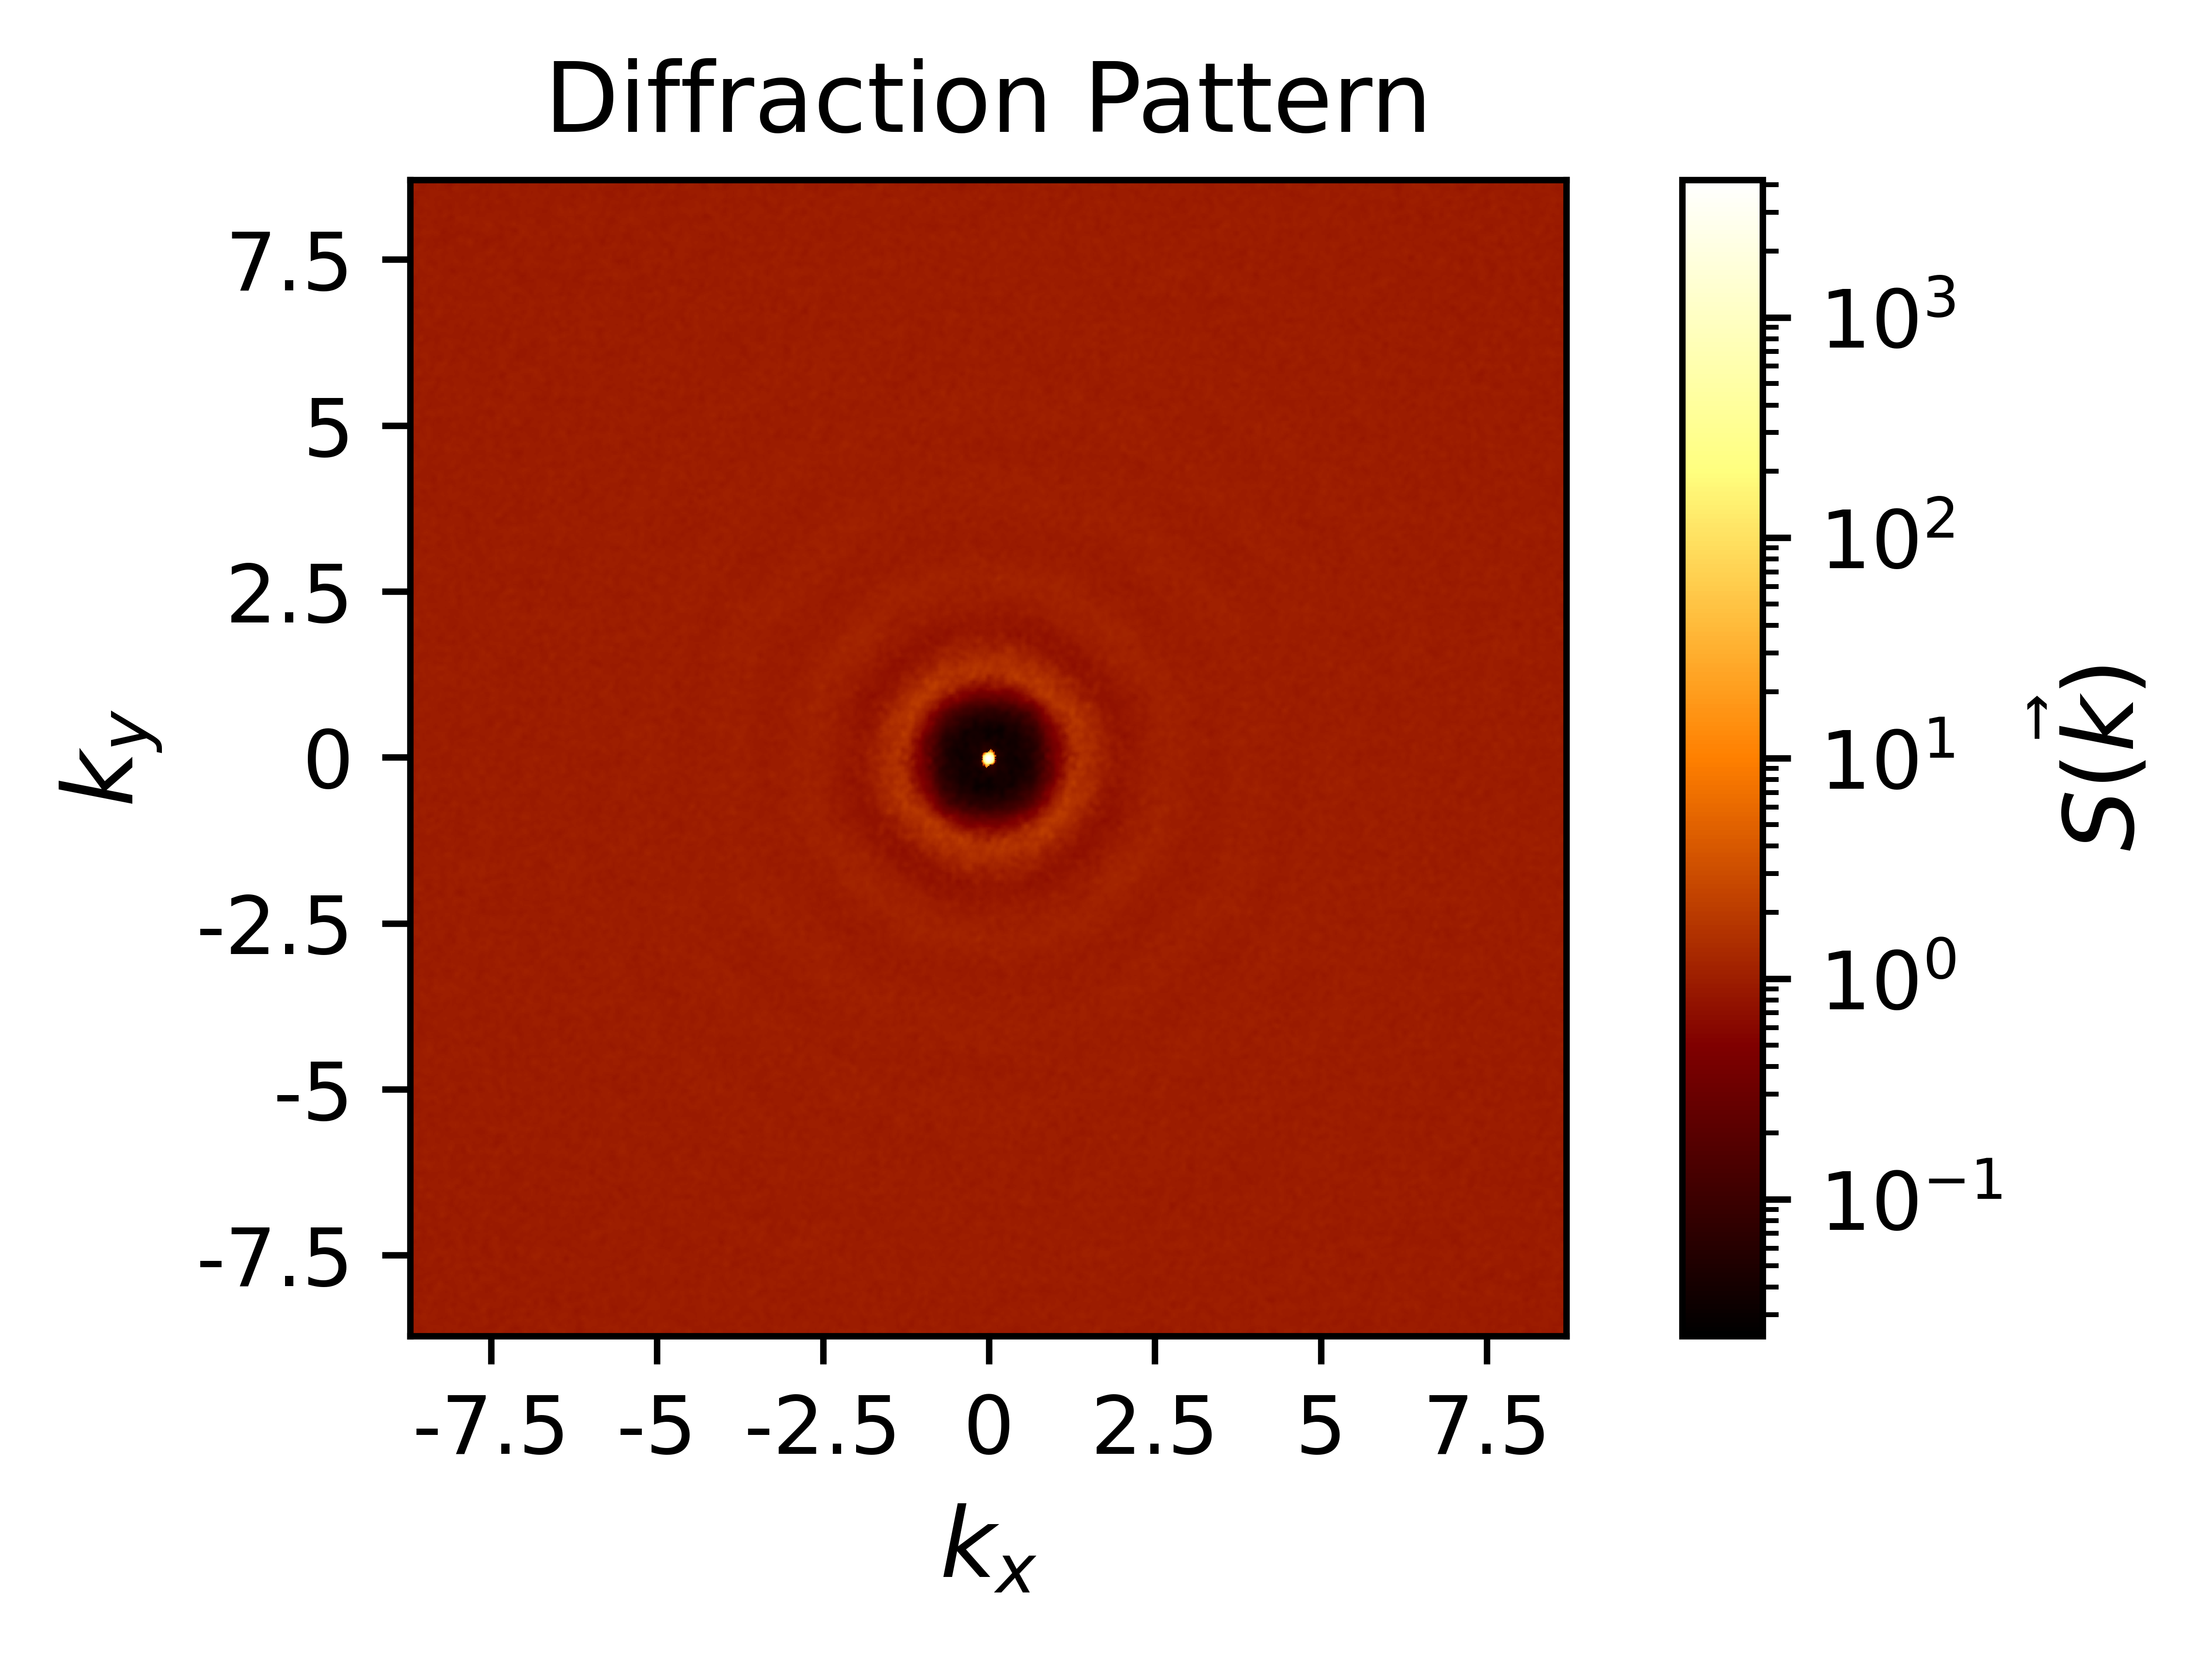

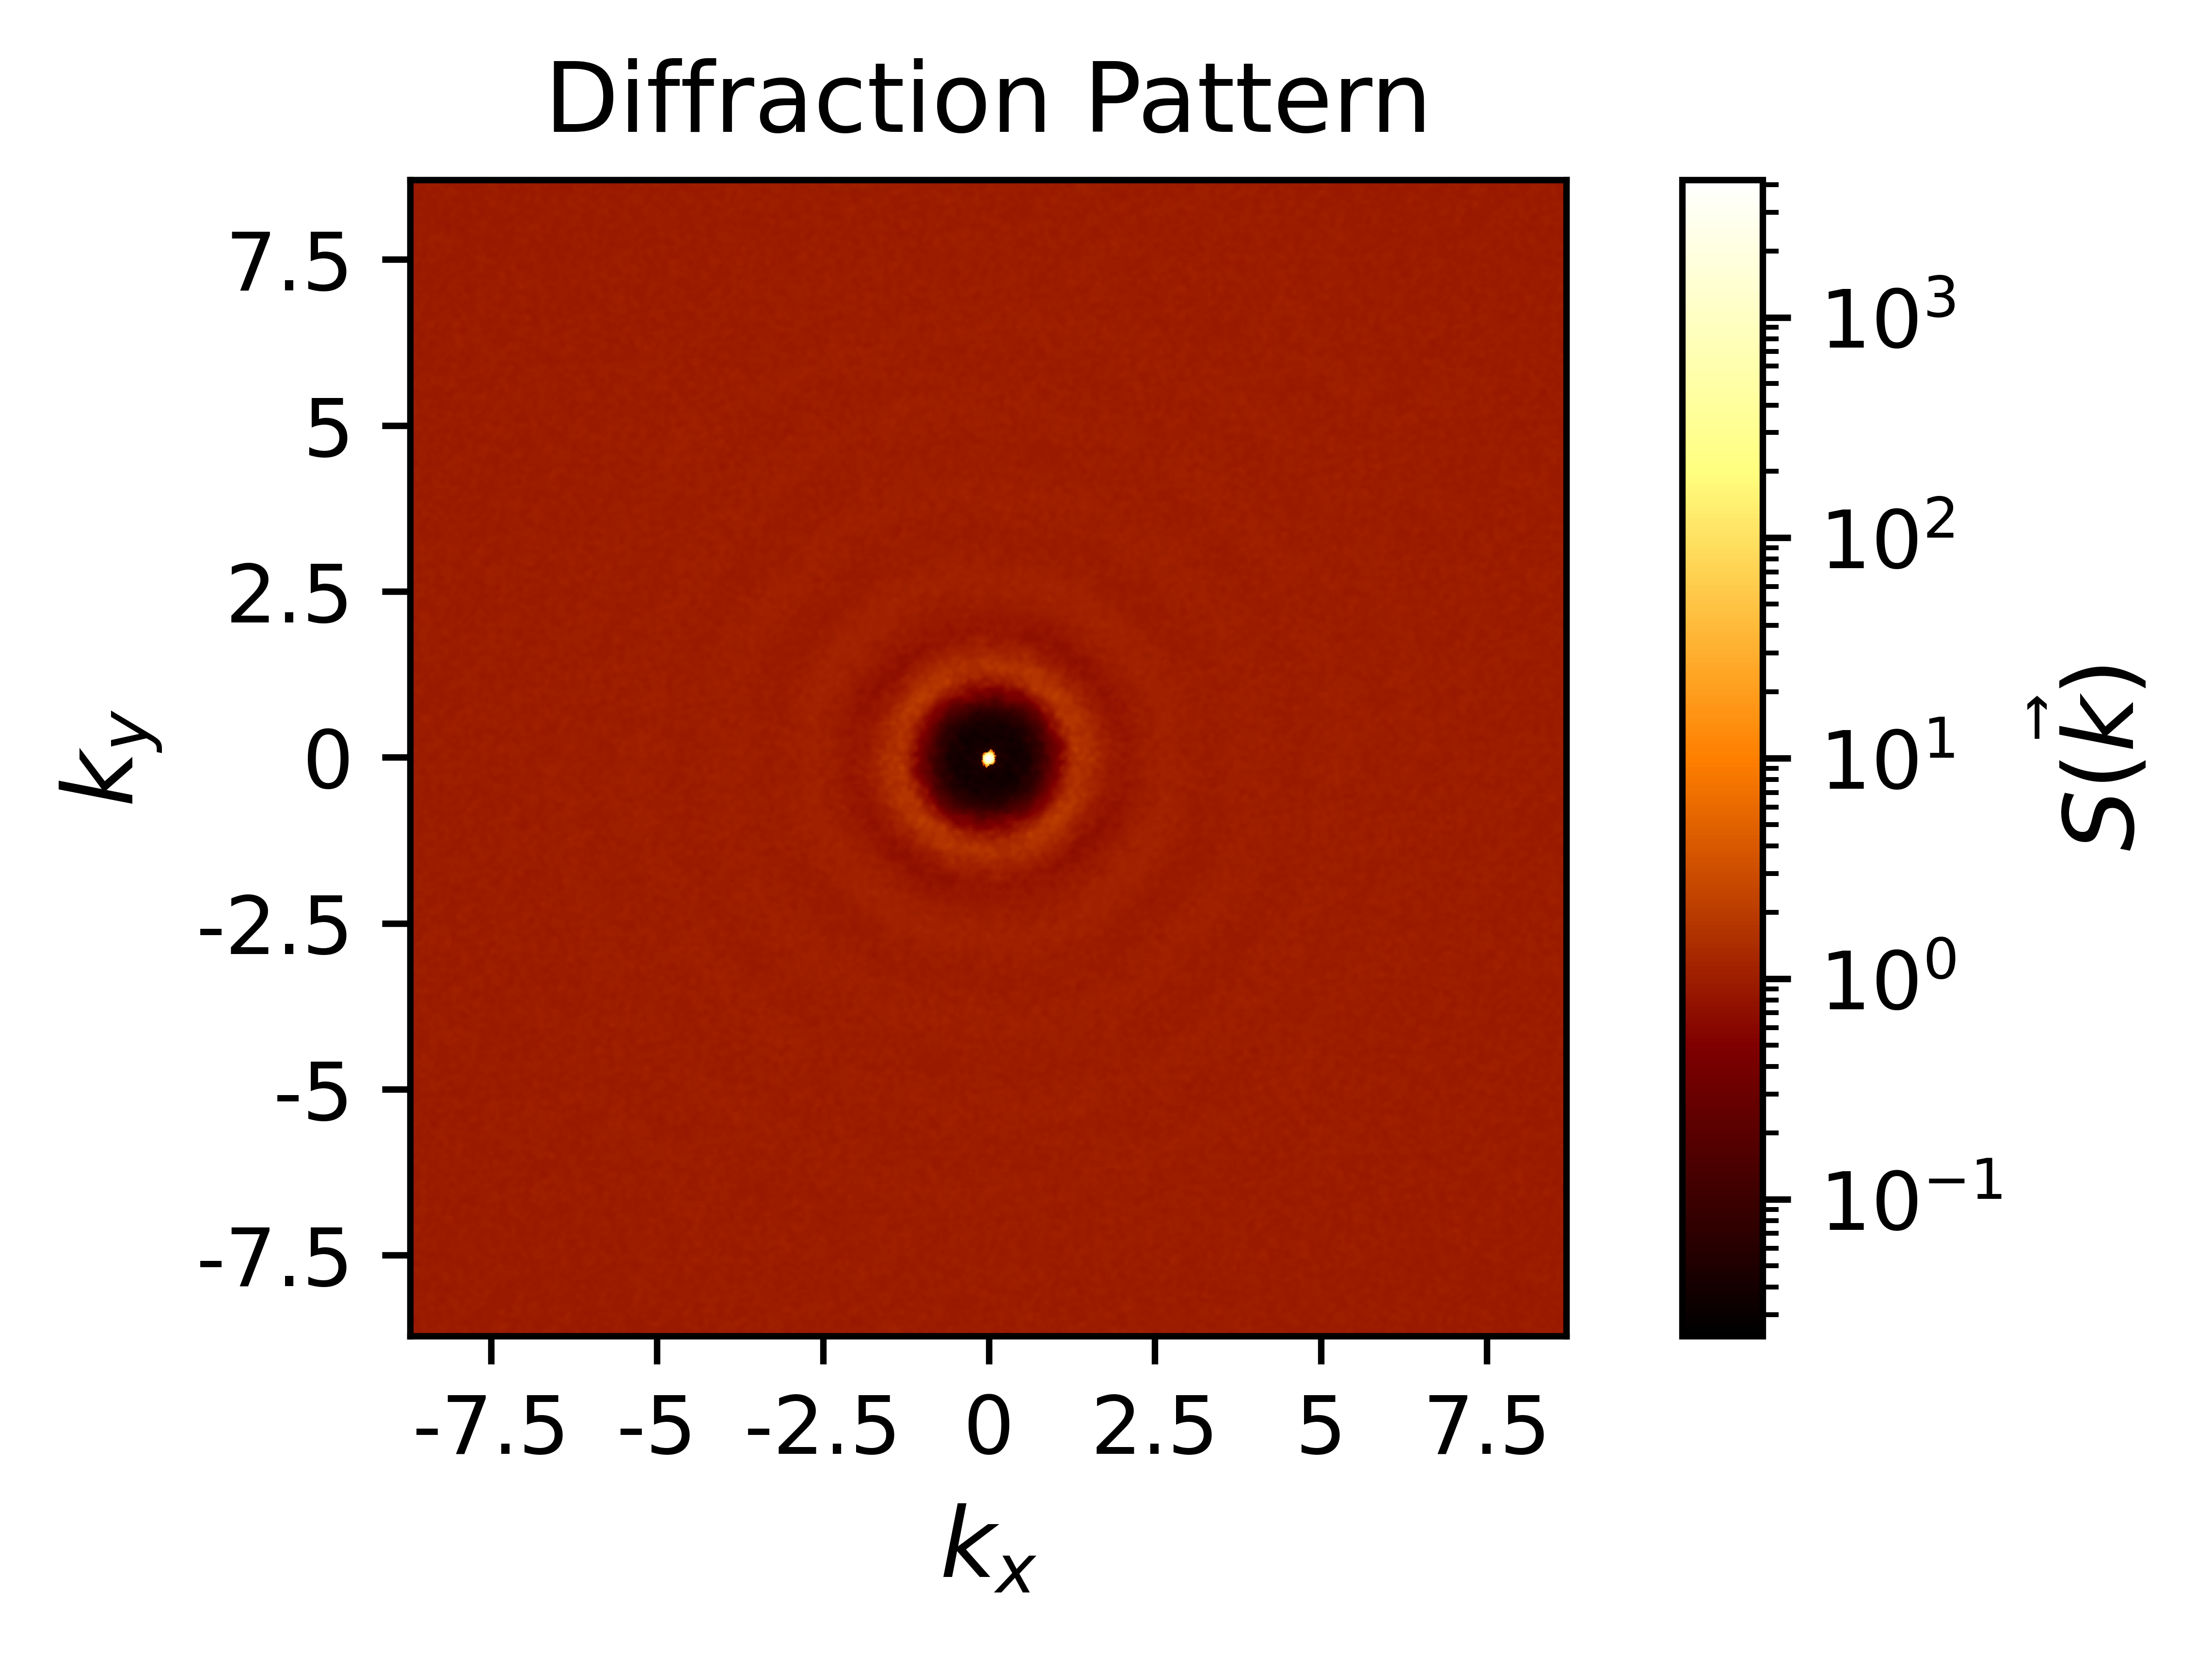

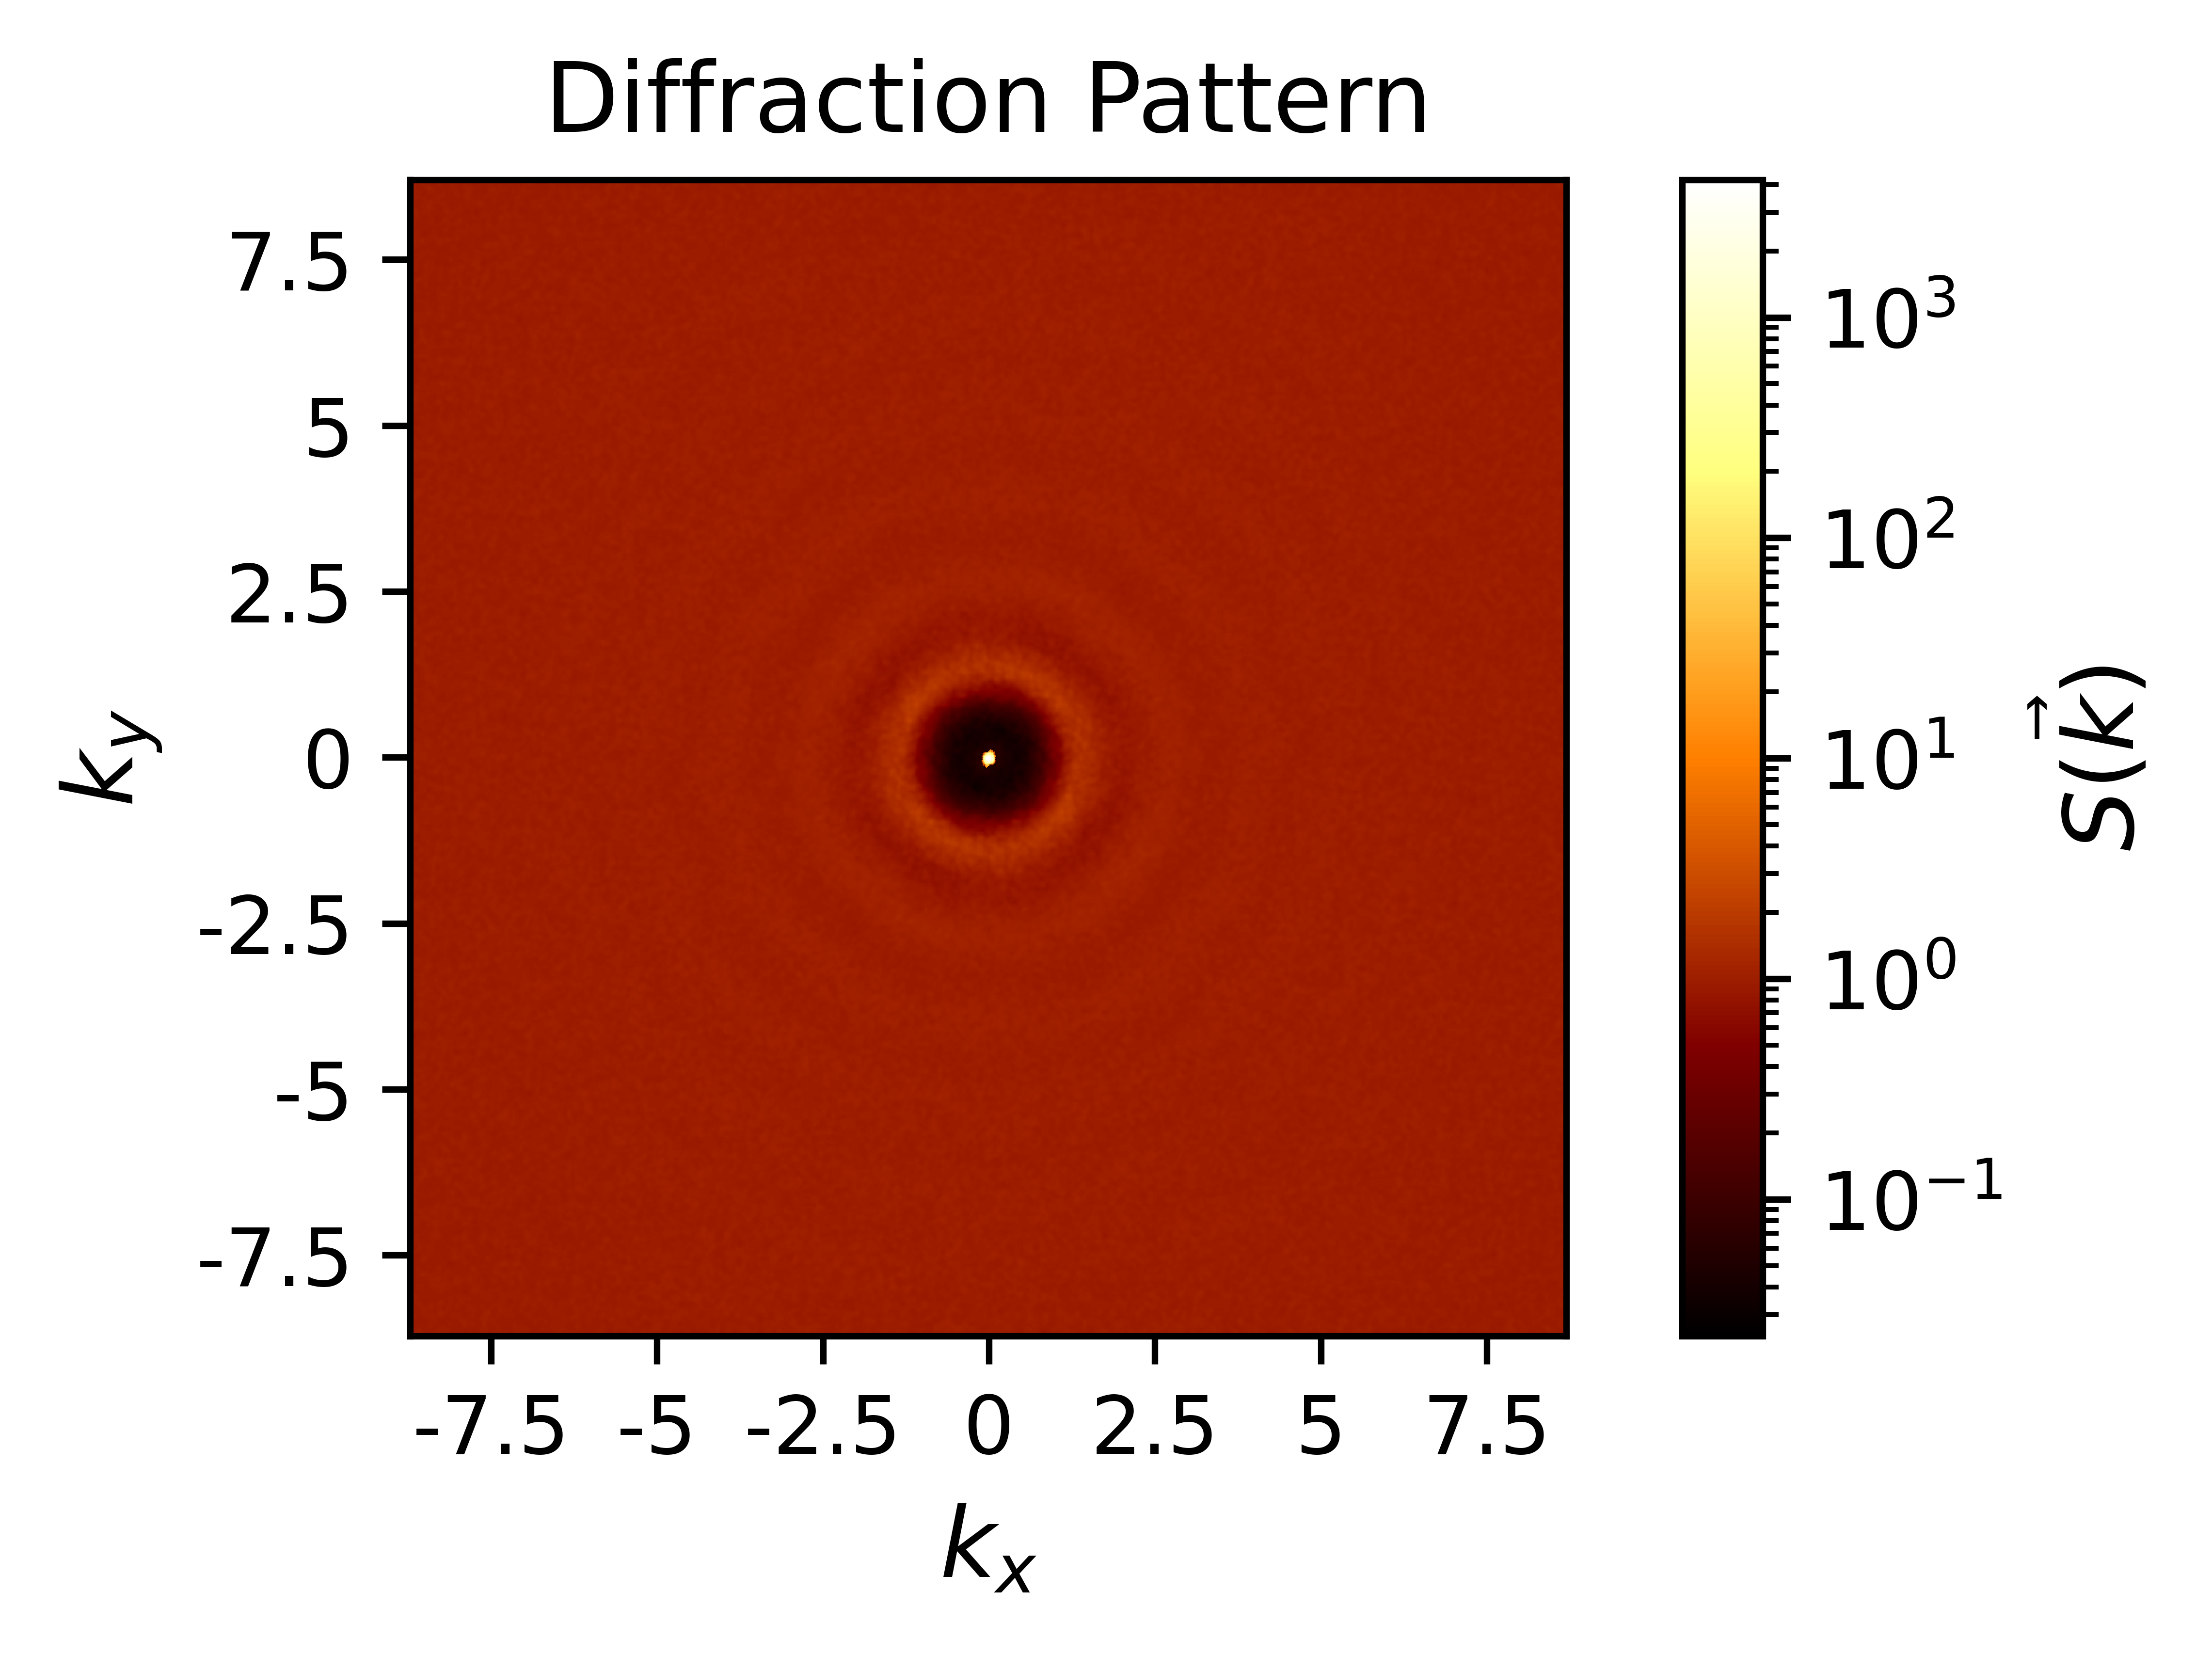

In [27]:
quarternions = get_quaternions(n_views=20)

for weight, jobs in project.find_jobs({"kT_quench": 1.2}).groupby("ekk_weight"):
    for job in jobs:
        dp = diffraction_pattern(
            gsdfile=job.fn("sim_traj.gsd"),
            views=quarternions,
            ref_length=job.doc.ref_distance,
            start=-20,
            stop=-1
        )
        print(job.sp.ekk_weight)
        dp.plot()
        

In [3]:
def k_vector_to_2theta(k, wave_length):
    """"""
    d = 2*np.pi / k
    return 2 * np.arcsin(wave_length/(2*d))

/tmp/ipykernel_2274458/3688470987.py:4: RuntimeWarning: invalid value encountered in arcsin
  return 2 * np.arcsin(wave_length/(2*d))


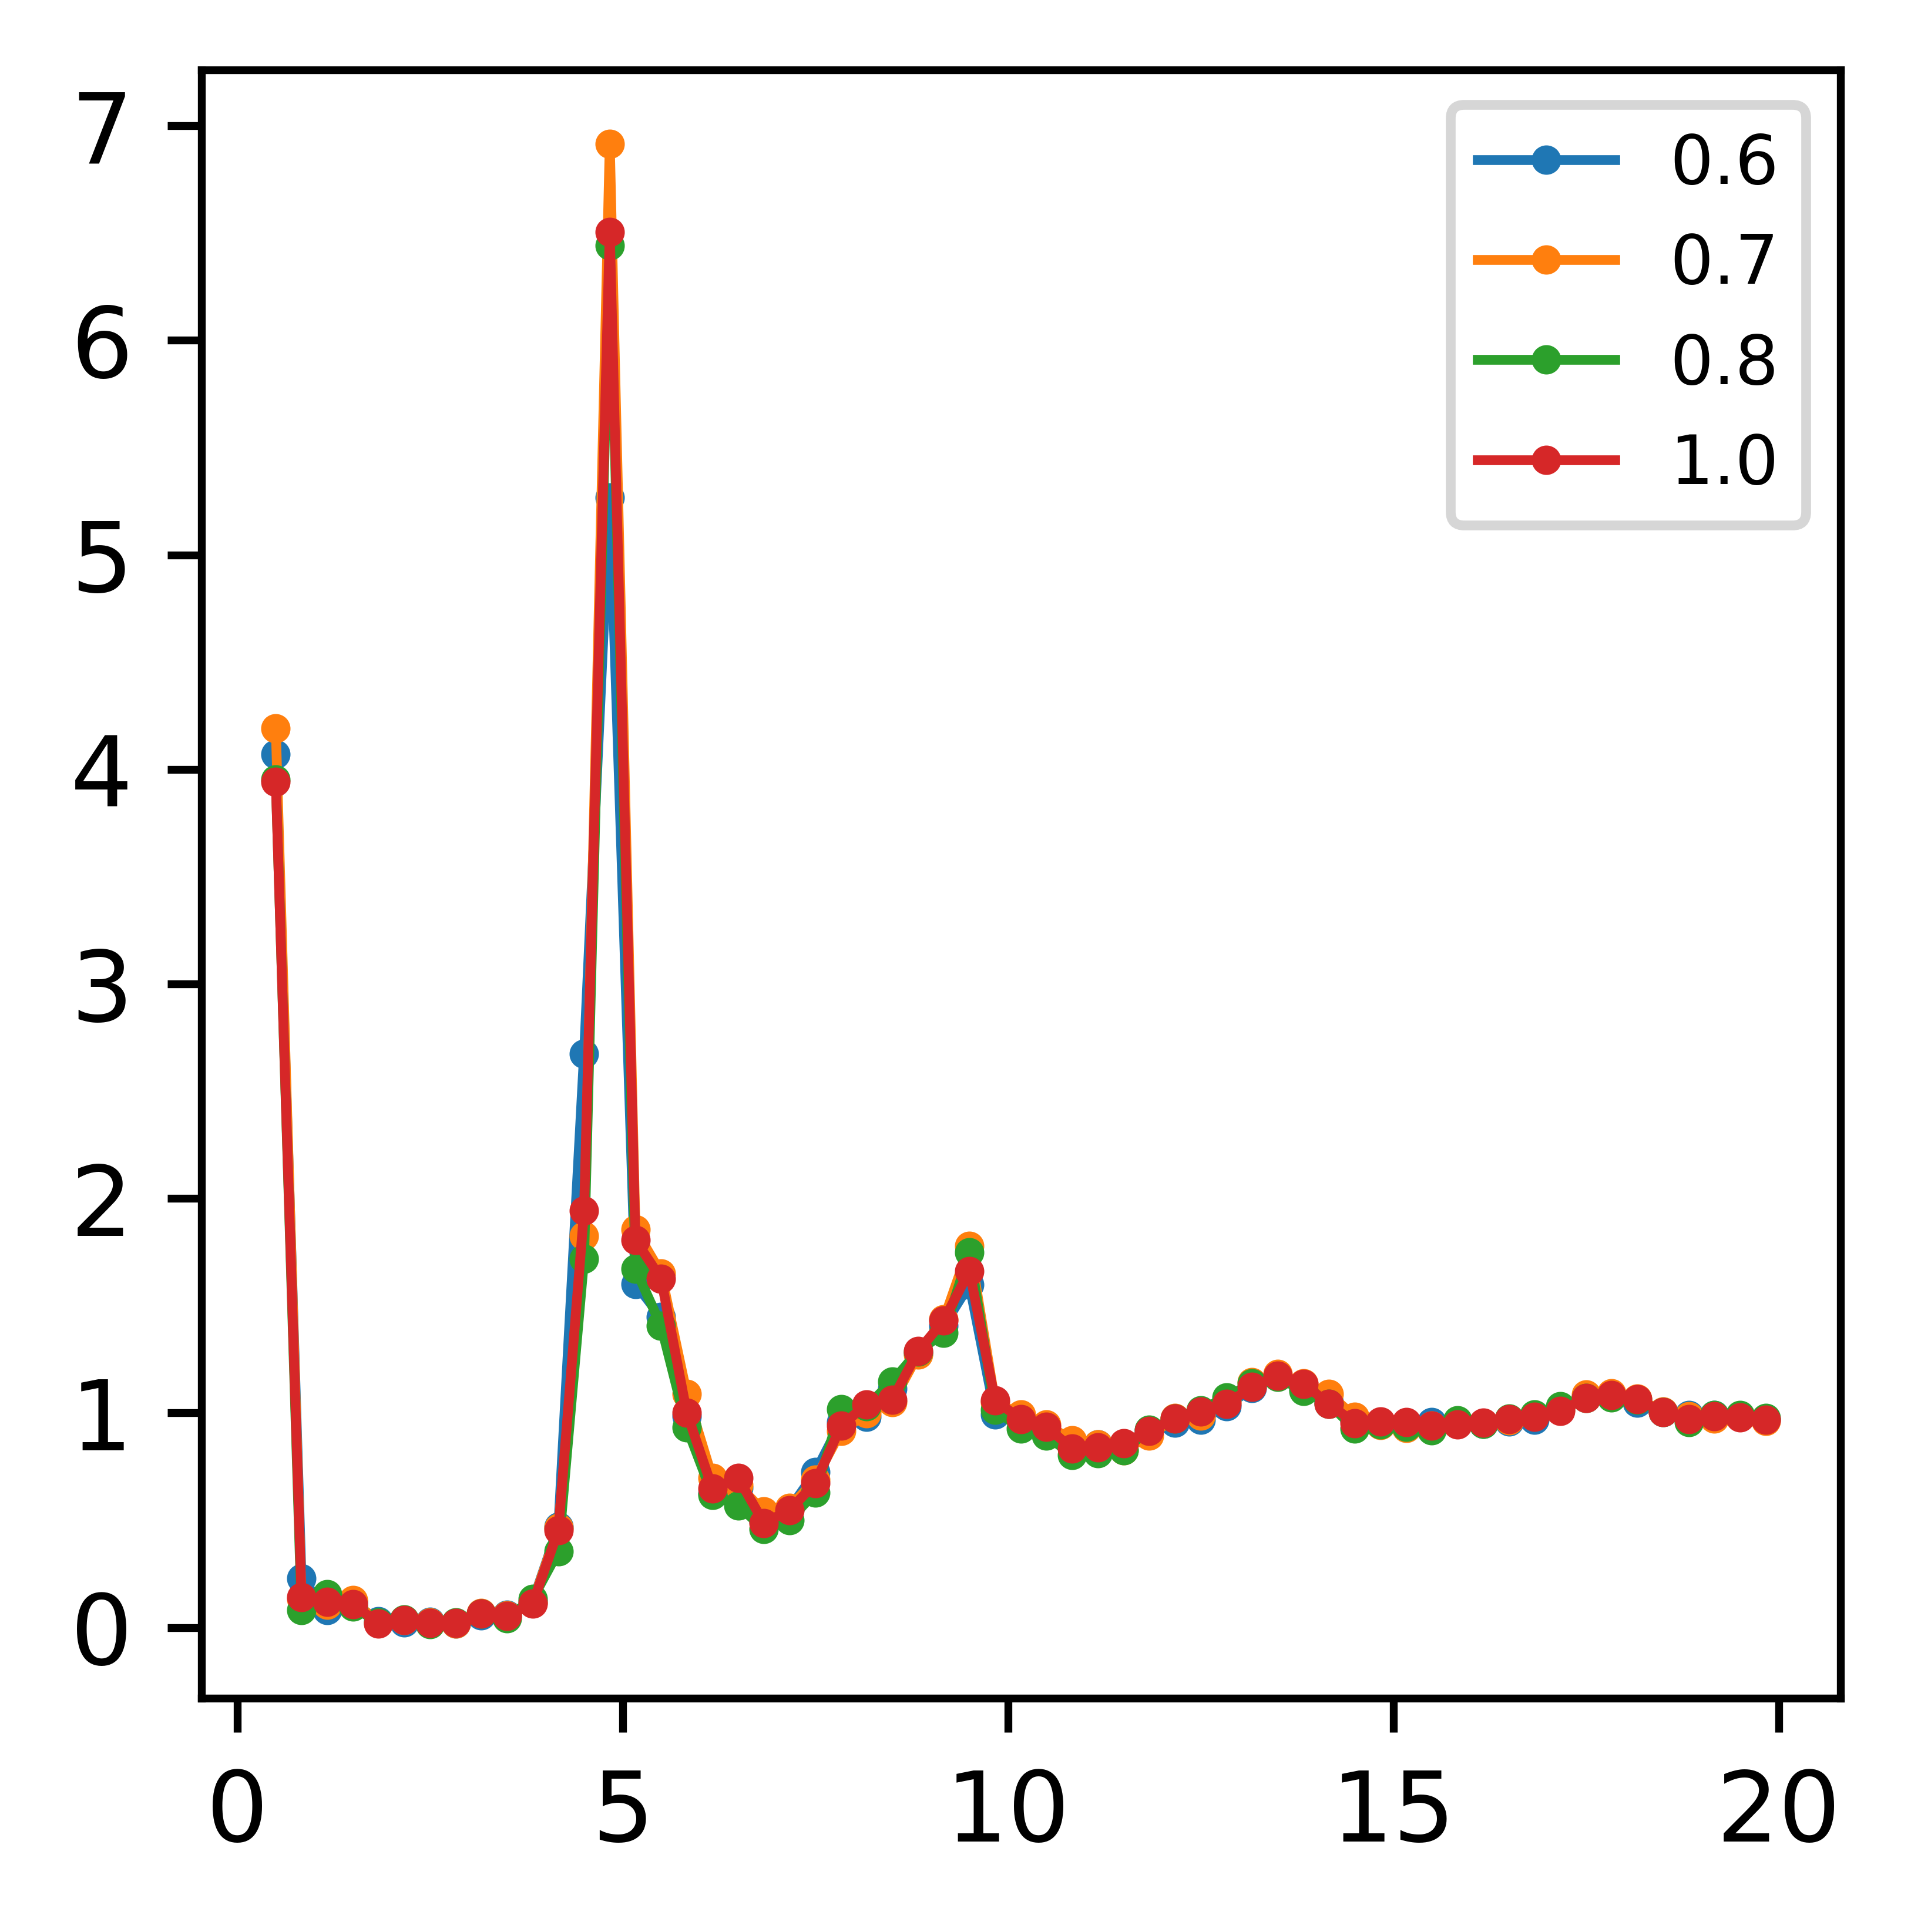

In [18]:
for weight, jobs in lattice_project.find_jobs().groupby("ekk_weight"):
    for job in jobs:
        sf = structure_factor(
            gsdfile=job.fn("sim_traj.gsd"),
            ref_length=1,
            start=-2,
            stop=-1,
            bins=60,
            k_max=20,
            k_min=0
        )
        thetas = k_vector_to_2theta(sf.bin_centers, wave_length=1.54)
        plt.plot(sf.bin_centers[1:], sf.S_k[1:], label=weight)
        
plt.legend()

In [6]:
thetas

array([0.04295942, 0.0567818 , 0.07060689, 0.08443536, 0.09826787,
       0.11210508, 0.12594766, 0.13979629, 0.15365164, 0.16751438,
       0.1813852 , 0.19526475, 0.20915376, 0.2230529 , 0.23696287,
       0.25088436, 0.26481811, 0.27876475, 0.2927251 , 0.30669978,
       0.32068962, 0.33469525, 0.34871752, 0.36275708, 0.37681473,
       0.39089131, 0.40498747, 0.41910412, 0.43324193, 0.44740183,
       0.46158451, 0.47579093, 0.4900218 , 0.50427809, 0.51856056,
       0.53287013, 0.54720775, 0.56157428, 0.57597058, 0.59039764,
       0.60485647, 0.619348  , 0.63387314, 0.64843296, 0.66302855,
       0.6776609 , 0.69233102, 0.70704005, 0.72178911, 0.73657941,
       0.75141203, 0.7662881 , 0.78120892, 0.79617577, 0.81118987,
       0.82625247, 0.84136496, 0.85652878, 0.87174527, 0.88701581])

In [7]:
sf.S_k

array([0.04631269, 0.03314809, 0.03314432, 0.03646928, 0.02790166,
       0.03330097, 0.03258374, 0.03507893, 0.0405718 , 0.05131026,
       0.06135097, 0.07506163, 0.09751537, 0.13076599, 0.18363006,
       0.26945424, 0.37436196, 0.576238  , 0.8420715 , 1.3712236 ,
       1.9277352 , 2.0669954 , 1.9623855 , 1.6060637 , 1.4842452 ,
       1.2594512 , 1.1346376 , 1.0136677 , 0.90296865, 0.7983393 ,
       0.74811023, 0.7077741 , 0.69995725, 0.71667403, 0.76463026,
       0.8017032 , 0.8397441 , 0.91511625, 0.9566755 , 0.9838636 ,
       1.0041354 , 1.0372015 , 1.0850395 , 1.1419382 , 1.1869645 ,
       1.1896745 , 1.186993  , 1.156876  , 1.0945984 , 1.0577272 ,
       1.0222188 , 0.9749269 , 0.9584314 , 0.93508464, 0.90022457,
       0.90278596, 0.8902598 , 0.9080646 , 0.9037581 , 0.93169487],
      dtype=float32)

In [8]:
d = 1/sf.S_k * np.pi * 2

In [9]:
d

array([135.66875  , 189.54895  , 189.57051  , 172.28705  , 225.19037  ,
       188.67873  , 192.83195  , 179.11565  , 154.86583  , 122.45475  ,
       102.413795 ,  83.707016 ,  64.43277  ,  48.04908  ,  34.216537 ,
        23.318192 ,  16.783718 ,  10.903803 ,   7.461582 ,   4.5821743,
         3.2593613,   3.0397675,   3.2018101,   3.9121644,   4.233253 ,
         4.988828 ,   5.5376143,   6.198467 ,   6.958365 ,   7.8703194,
         8.398743 ,   8.877388 ,   8.976528 ,   8.767145 ,   8.217286 ,
         7.837296 ,   7.4822617,   6.8659973,   6.567729 ,   6.386236 ,
         6.2573094,   6.057825 ,   5.7907434,   5.5022116,   5.293491 ,
         5.281432 ,   5.2933636,   5.4311657,   5.7401743,   5.9402704,
         6.1466146,   6.444776 ,   6.5556965,   6.719376 ,   6.979575 ,
         6.959773 ,   7.057699 ,   6.919316 ,   6.9522867,   6.743823 ],
      dtype=float32)

<AxesSubplot: title={'center': 'Static Structure Factor'}, xlabel='$k$', ylabel='$S(k)$'>

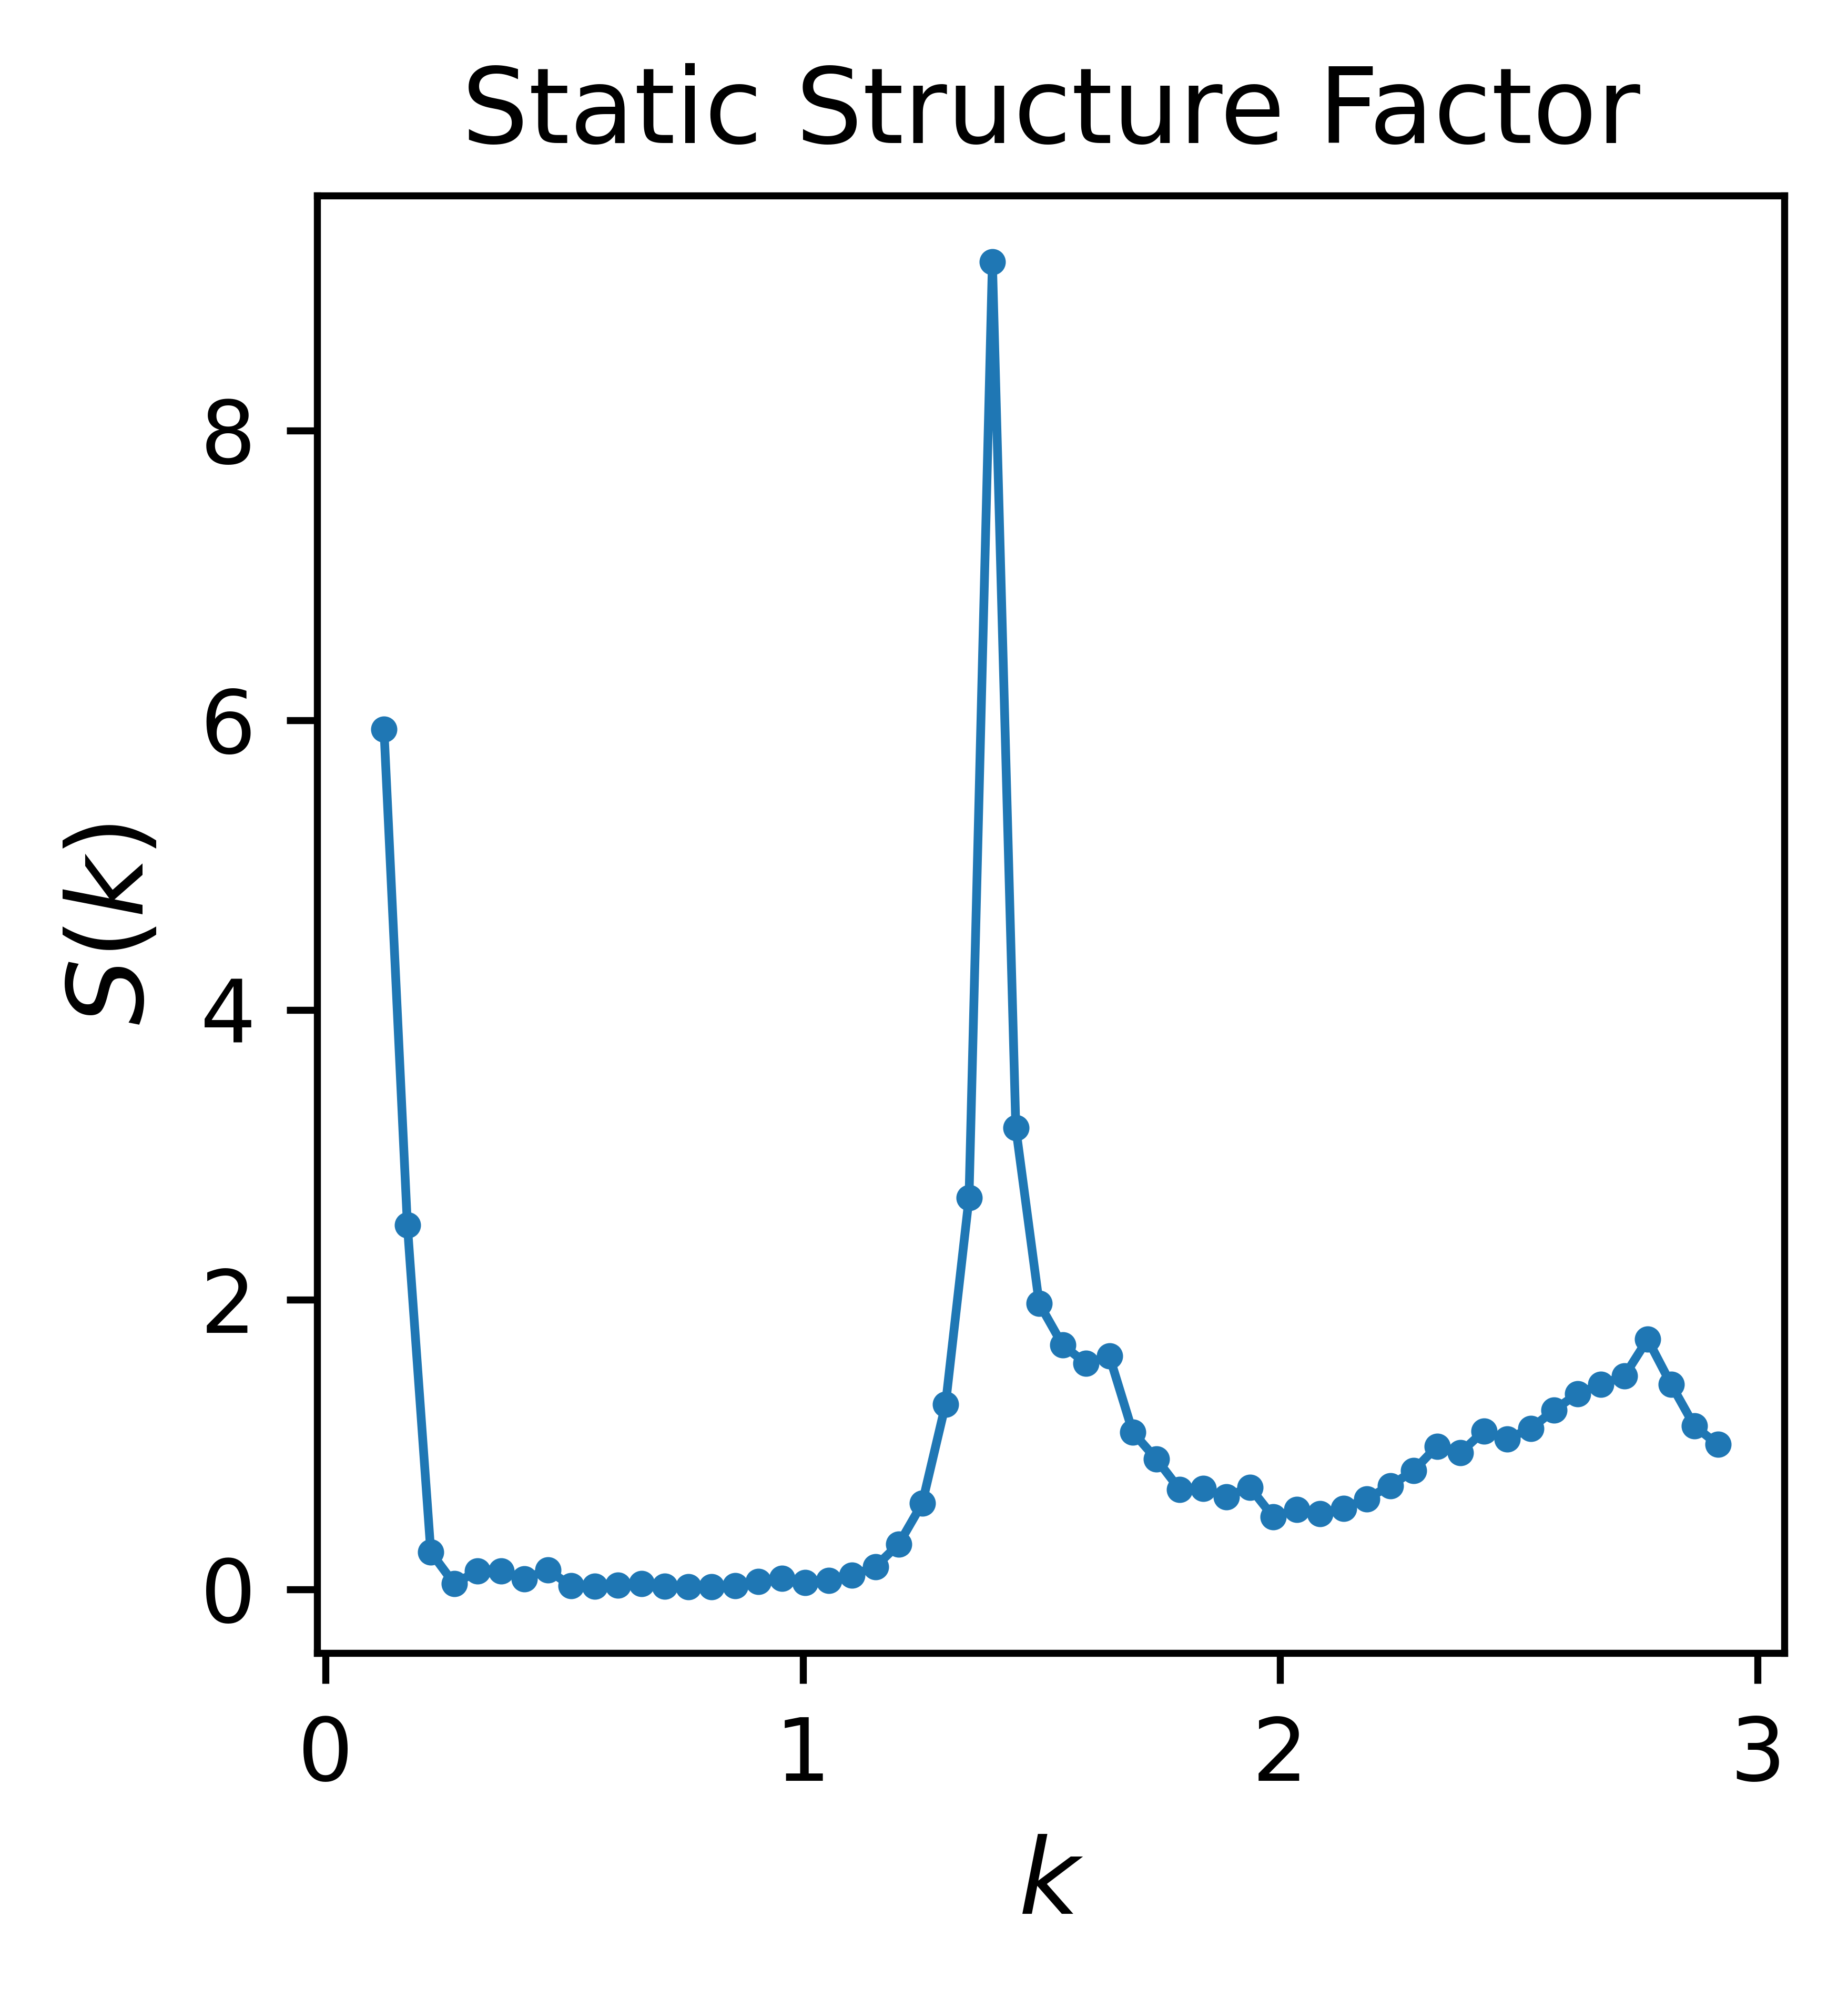

In [17]:
sf.plot()